# 5TF078 Deep Learning Course
## Laboration 3 om Tidsserier/RNN
Created by Tomas Nordström, Umeå University

This is a brief introduction to tensors as used in Tensorflow/Keras 

Revisions:
*   2023-04-20 Initial version /ToNo

*Glöm inte ditt namn!*

# Introduktion

Laborationens mål är att använda ett återkopplat neuronnät (eng. Recurrent Neural Network, RNN) modell (t.ex. LSTM) för att göra prediktioner av en tidsserie av väderdata. 

# Python Setup

In [1]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# from tensorflow import keras
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, \
                         MaxPooling2D, Input, Activation, Add, LSTM, GRU, TimeDistributed,Lambda, Reshape
from keras.utils  import to_categorical, plot_model, Sequence, timeseries_dataset_from_array
# Optimizers
# Check if macos system
from keras.optimizers import RMSprop, Adagrad, SGD

# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

# print('Keras version:',tf.keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries
import os
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns
# Typing imports for type hints / readability
from typing import Tuple, List, Dict, Any, Union
import os
import sys
# NOTE: Fix the seed for reproducability
np.random.seed(0)
tf.random.set_seed(0)

2023-05-03 08:56:45.338365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 08:56:46.442374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-05-03 08:56:46.442429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-05-03 08:56:46.442434: W tensorflow/compiler/tf2t

TensorFlow version: 2.11.0


In [2]:
# Test for GPU and determine what GPU we have
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
  !nvidia-smi -L

# If possible to run code wiht 16 bits float instad of 32 bits float, this code acitvates such functionality:
if gpu_devices:
 details = tf.config.experimental.get_device_details(gpu_devices[0])
 compute_capability=details.get('compute_capability')
 print("Compute capability:",compute_capability)
 if compute_capability[0]>6:
   print("Turning on mixed_float16")
   policy = tf.keras.mixed_precision.Policy('mixed_float16')
   tf.keras.mixed_precision.set_global_policy(policy)

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-d19262ea-7136-1ab7-a1e9-2e1f76960c50)
Compute capability: (8, 6)
Turning on mixed_float16
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


2023-05-03 08:56:48.027464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:48.054936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:48.055219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:48.252024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:48.252530: I tensorflow/compiler/xla/stream_executo

# Del 1:  Första delen av uppgiften har följande underdelar
* Förstå dataförbehanlingen som görs nedan, dels att förbereda tidssekvensen med dess olika parametrar, dels förstå hur han skapar sekvenser/fönster som kan användas för att träna våra RNN-modeller.
* Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem
* Skapa en baseline att jämföra med
* Träna en enkel LSTM modell för att prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

In [3]:
N_PREV_STEPS = 24
BATCH_SIZE = 512
TEMP_KEY = 'T (degC)'

## Som data används väderdata

Denna laboration använder en <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">vädertidsserie</a> uppmätt vid av Max Planck Institute for Biogeochemistry.

Denna datauppsättning innehåller 14 olika parametrar som lufttemperatur, atmosfärstryck och luftfuktighet. Dessa samlades in var tionde minut, med början 2003. För att vara lite effektiva kommer du endast att använda data som samlats in mellan 2009 och 2016. Den här delen av datamängden förbereddes av François Chollet för sin bok [`Deep Learning with Python`](https:// www.manning.com/books/deep-learning-with-python).


## Climate Data Time-Series
**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

In [5]:
# This lab will just deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:
df = df[5::6] # starting from index 5 take every 6th record.

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [6]:
print(df.shape)
# Let's take a glance at the data. Here are the first few rows:
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

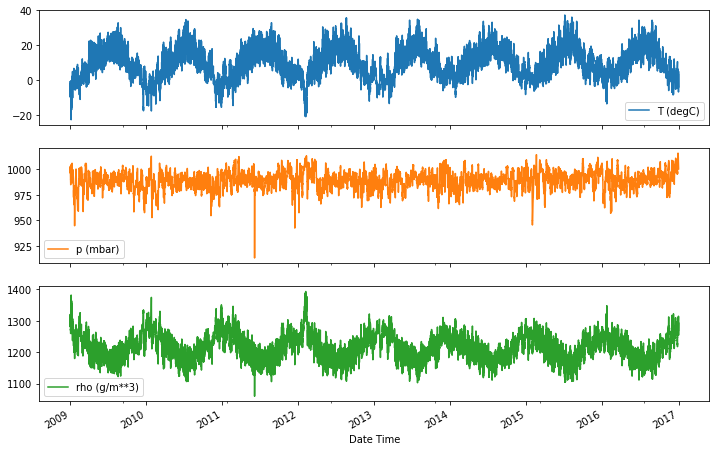

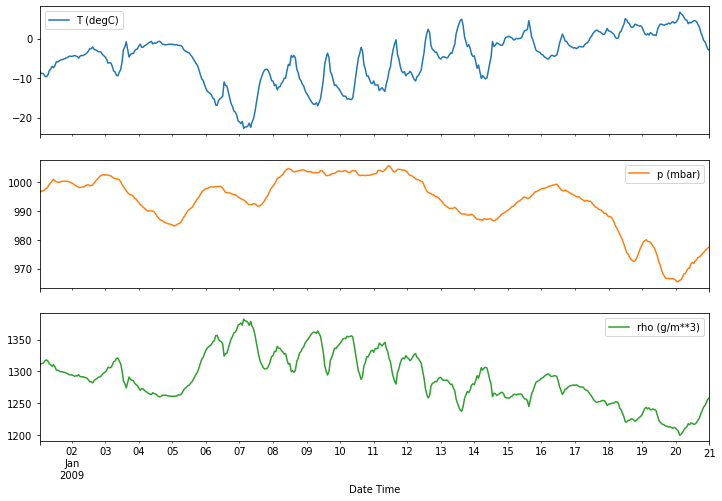

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(12, 8))

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, figsize=(12, 8))

### Inspect and cleanup

Next look at the statistics of the dataset:

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

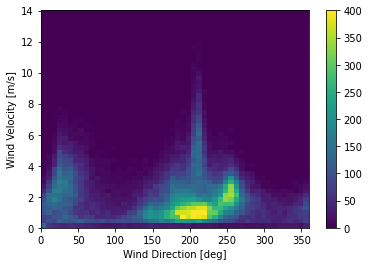

In [11]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [12]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

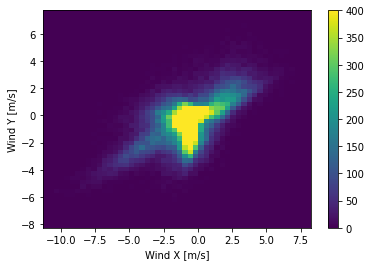

In [13]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [14]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [15]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

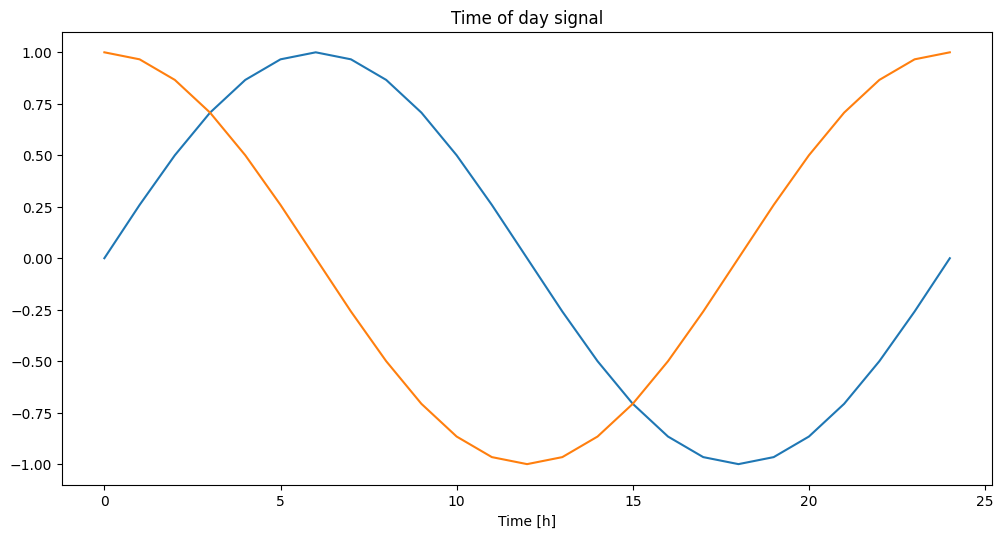

In [16]:
plt.figure(figsize=(12, 6),dpi=100)
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

2023-05-03 08:56:52.449165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 08:56:52.450189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:52.450519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 08:56:52.450766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

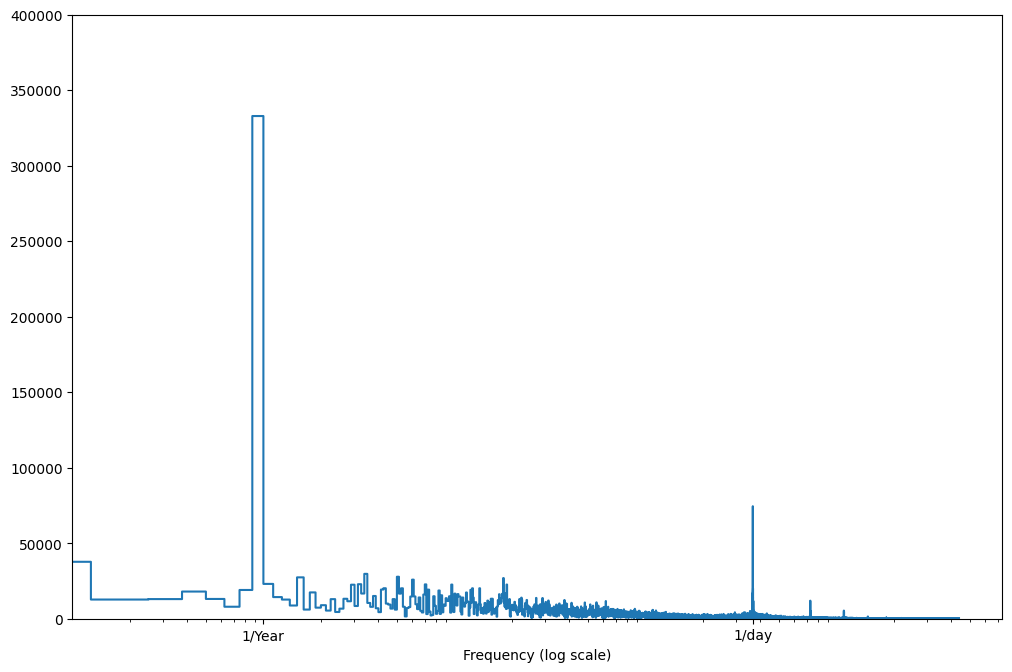

In [17]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(12, 8),dpi=100)
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Uppgift Besvara följande frågor
Denna kod gör ganska omfattande förbehandling av väderdatat innan man kan använda det för träning, se till att du förstår vad som sker och beskriv följade:
* Det finns en eller flera variabler med extrema (fysiskt omöjliga) värden, vilka är det, och vad görs för att hantera dem?
* Varför har maskininlärningsmodeller svårt att hantera en vindriktning som anges i grader, vad föreslås som alternativ att representera vindriktning istället?
* Även tid, mätt i sekunder/timmar etc. gör det onödigt svårt för modeller att hitta mönster i vissa typer av tidsserier, vad för slags variabler föreslås i koden att man lägger till för väderdata? Om detta istället hade varit energiförbrukningsdata, vilken periodisitet borde man då utökat med?

## Svar
1. En variabel med fysiskt omöjliga värden är genomsnittliga och maximala vindstyrkan över perioden, `wv (m/s)` respektive `max wv (m/s)`. Väderstationen hade uppmätt en minimal vinderstyrka på $-9999$ (m/s) vilket inte är möjligt då vindstyrkan bör var större än eller lika med noll (m/s). Detta hanteras genom att ersätta alla avläsningar då vindstyrkan uppnått detta värde till noll.
2. Maskininlärningsmodeller har svårt att hantera vindriktning givet i grader p.g.a. den periodiska aspekten av en vinkel. 
   $$\theta=360^\circ\equiv\theta=0^\circ$$
   Därav ersätts vinkelriktningen med två nya variabler `Wx` och `Wy` för att representera komposanterna av vinden. Dessa komponenter bildar tillsammans den mellanliggande vinkeln enligt förhållandet
   $$\theta = \arctan \frac{W_y}{W_x},$$
   Där $W_y=W_v\sin\theta$ och $W_x=W_v\cos\theta$.
   På så sätt bevaras informationenen samt ger modellen ett enkelt sätt att förstår den periodisk informatioenen.
3. Man omvandlar tid till en periodisk cykel av dagar/år. Dagar och år delas upp i en cosinus samt sinus kurva. Dessa kurvor kan ses beskriva hur mycket dag/natt respektiva sommar/vinter det är given en tidpunkt. Sinus kruvorna representerar hur mycket dag och vinter det är medan cosinus representerar natt / sommar. Man kan se detta genom att studera figuren ovan, `Time of day signal`. För att representera energiförbrukingsdata kan man använda sig av en liknande cosinus och sinus uppsättning av kruvor kombinerat med konsumptionen. Eftersom konsumptionen varierar årligt och dagligt anser jag att det vore lämpligt att använda en likande modell som för tiden.

## Datauppdelning och fönster

Förutom att dela upp denna tidsserie i våra tre olika datamängder behöver vi konvertera tidsserien till kortare sekvenser/fönster och lämpliga utvärden (motsvarande de "labels" vi använde i Lab 1&2).

Detta med fönster kan vara lite svårt att få ordning på så jag har skapat en lite introduktion här: https://colab.research.google.com/drive/1GU3WWJ4c3KWa8xrj5bZdnJp5PaIDjWYr?usp=sharing

## Back to our real data, start by finding splitting points

In [18]:
# Find index to where we want to split our data into our datasets
DataSplitRatios=(0.7,0.2,0.1) # Maybe one should check this sums up to 1?
n = len(df)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1]))
print(split1ix,split2ix,n)

49063 63081 70091


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.
Note that the mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

The data is normalized so that the data is in the same distribution which makes the models to be able to learn easier.

In [19]:
train_mean = df[0:split1ix].mean()
train_std = df[0:split1ix].std()
dfnorm = (df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

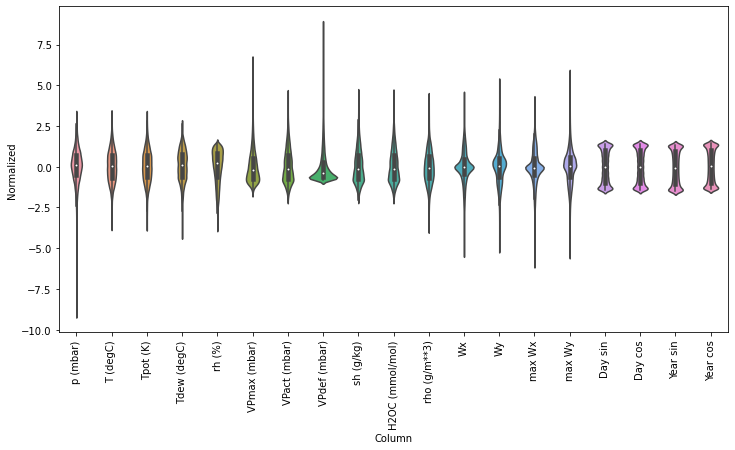

In [20]:
df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Uppgift Del 1
Vi ska prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

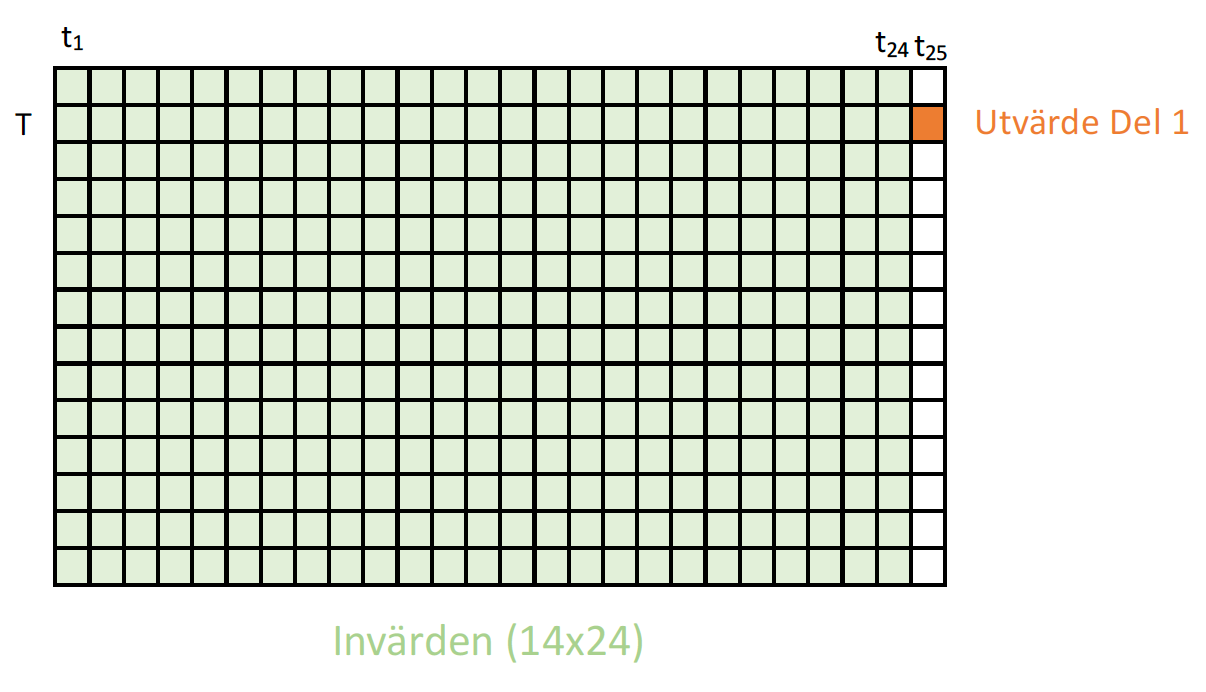

Notera att figurerna visar bara 14 parametrar, men efter utvidgningarna så är det egentligen 19 parametrar.

## Förbered våra tre "dataset"

In [21]:
# Help function to get indices for columns based on column names
def get_label_columns_indices(dataframe, label_columns=None):
  if label_columns is not None:
    label_columns_indices = {name: i for i, name in enumerate(label_columns)}
  else:
    label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
  return label_columns_indices

In [22]:
# Test get_label_columns_indices
#lcol= ['T (degC)']
all_lcol= None
all_lci = get_label_columns_indices(dfnorm,all_lcol)
print(all_lci)

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}


In [138]:
# Here is our function that take our time sequence data and convert it to a dataset 
# that then can be us as a dataset for training or evaluation
def datasetgen(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
               label_columns=None, start_index=None, end_index=None, shuffle=False):
  offset = input_width+shift-1         # offset to where targets start (and input ends)
  input_data = dataframe[:-offset]   # Input up until where the target starts
  label_columns_indices = get_label_columns_indices(dataframe, label_columns) # get the selected columns
  targets = dataframe[list(label_columns_indices)]
  targets = targets[offset:]         # Output from end of input and for the selected columns
  # Here we create the windows and store them as a dataset using 'timesesries_dataset_from_array'
  ds = timeseries_dataset_from_array(
    input_data, targets, sequence_length=input_width,
    sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
    start_index=start_index, end_index=end_index)
  for batch in ds.take(1):
      inputs, targets = batch
      print(f"Number of samples: {len(ds)}")
      print('Input shape:', inputs.shape)
      print('Target shape:', targets.shape)
  return ds
# Now create the used datasets for part 1
lcol=['T (degC)']
lci = get_label_columns_indices(dfnorm, lcol)
input_lci = dict((k, all_lci[k]) for k in all_lci.keys() if k in list(lci.keys()))
shift = 1
def train_val_test(shift, n_outputs,lcol:list=['T (degC)']):
    train_ds = datasetgen(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift, 
                label_columns=lcol, start_index=0, end_index=split1ix, batch_size=BATCH_SIZE)
    val_ds = datasetgen(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift, 
                label_columns=lcol, start_index=split1ix, end_index=split2ix, batch_size=BATCH_SIZE)
    test_ds = datasetgen(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift,
                label_columns=lcol, start_index=split2ix, end_index=None, batch_size=BATCH_SIZE)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = train_val_test(shift, 1)


Number of samples: 96
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 28
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 14
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>


In [139]:
# Establish test targets (unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# And number of features
num_target_features = targets.shape[1]
print(f"Number of target features: {num_target_features}")


Number of target features: 1


In [140]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  input_shape = inputs.shape[1:]
  break
# Print dataset size
nobatches = eval_ds.__len__()
print("No sequences =", nobatches.numpy() * batchlen)

Input shape = (512, 24, 19), Output shape = (512, 1)
No sequences = 7168


### Now we can use the datasets needed for training

## Uppgift: 
Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem (mean squared error, MSE, eller mean absolute error,  MAE, eller något annat?) och varför denna exempelkod väljer att  använda just “loss=tf.losses.MeanSquaredError()” och “metrics=tf.metrics.MeanAbsoluteError()”.  Tillägna en sektion i din rapport till att argumentera för skillnaden mellan en förlustfunktion (loss) och ett prestationsmått (metric), samt motivera ditt val av förlustfunktion.



You will train a lot of models, so it might be useful to package the training procedure into a function:

In [141]:
MAX_EPOCHS = 5
def compile_and_fit(model:Model, train_ds, val_ds, patience=5,label_metric_index:int=-1):
   
   def last_time_step_mse(Y_true, Y_pred):
      return keras.metrics.mean_squared_error(Y_true[:, label_metric_index], Y_pred[:, label_metric_index])
   
   loss_func = tf.losses.MeanSquaredError()
   optimizer = tf.optimizers.legacy.Adam(learning_rate=0.001)
   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=patience,
                                                   mode='min',
                                                   restore_best_weights = True)
   reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6) 

   model.compile(loss=loss_func,
               optimizer=optimizer,
               metrics=[last_time_step_mse])

   history = model.fit(train_ds, epochs=MAX_EPOCHS,
                     validation_data=val_ds,
                     callbacks=[early_stopping,reduce_lr])
   return history, model



## Skapa en Modell

In [142]:
# Define a first simple LSTM model with 32 units
lstm_model_baseline = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_target_features),
    Reshape([1, num_target_features]),
])

output = lstm_model_baseline(Input(shape=input_shape))

Compile and train this model, and then plot the training curves. That is, the following graph shows the baseline LSTM model with a 24 sized(timepoints) array as input and a 1 sized output prediction(next timepoint).

In [143]:
# Compile and train this model
history_lstm_baseline,lstm_model_baseline = compile_and_fit(lstm_model_baseline, train_ds=train_ds,val_ds=val_ds)

Epoch 1/5
96/96 [==============================] - 3s 15ms/step - loss: 0.2391 - last_time_step_mse: 0.2387 - val_loss: 0.0439 - val_last_time_step_mse: 0.0436 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0438 - last_time_step_mse: 0.0438 - val_loss: 0.0283 - val_last_time_step_mse: 0.0280 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 1s 12ms/step - loss: 0.0274 - last_time_step_mse: 0.0273 - val_loss: 0.0222 - val_last_time_step_mse: 0.0220 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 1s 12ms/step - loss: 0.0213 - last_time_step_mse: 0.0213 - val_loss: 0.0189 - val_last_time_step_mse: 0.0188 - lr: 0.0010
Epoch 5/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0187 - last_time_step_mse: 0.0187 - val_loss: 0.0183 - val_last_time_step_mse: 0.0181 - lr: 0.0010


Test accuracy: 0.017


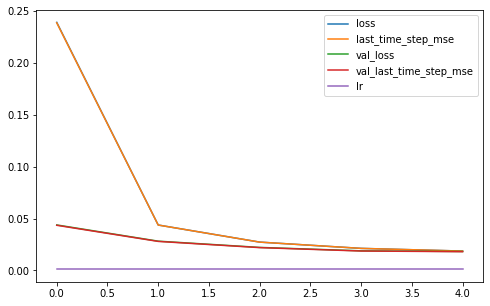

In [144]:
# Evaluate the model.
test_loss, test_acc = lstm_model_baseline.evaluate(test_ds, verbose=0)
print('Test accuracy: %.3f' % test_acc)

# Plot the training curves
pd.DataFrame(history_lstm_baseline.history).plot(figsize=(8,5))
plt.show()

Note that this is the normalised loss!

## Example plot of predictions

Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (1, 1)
Prediction shape = (1, 1)
Target shape = (512, 1)
Inpurt shape = (24,), Target shape = (1,)


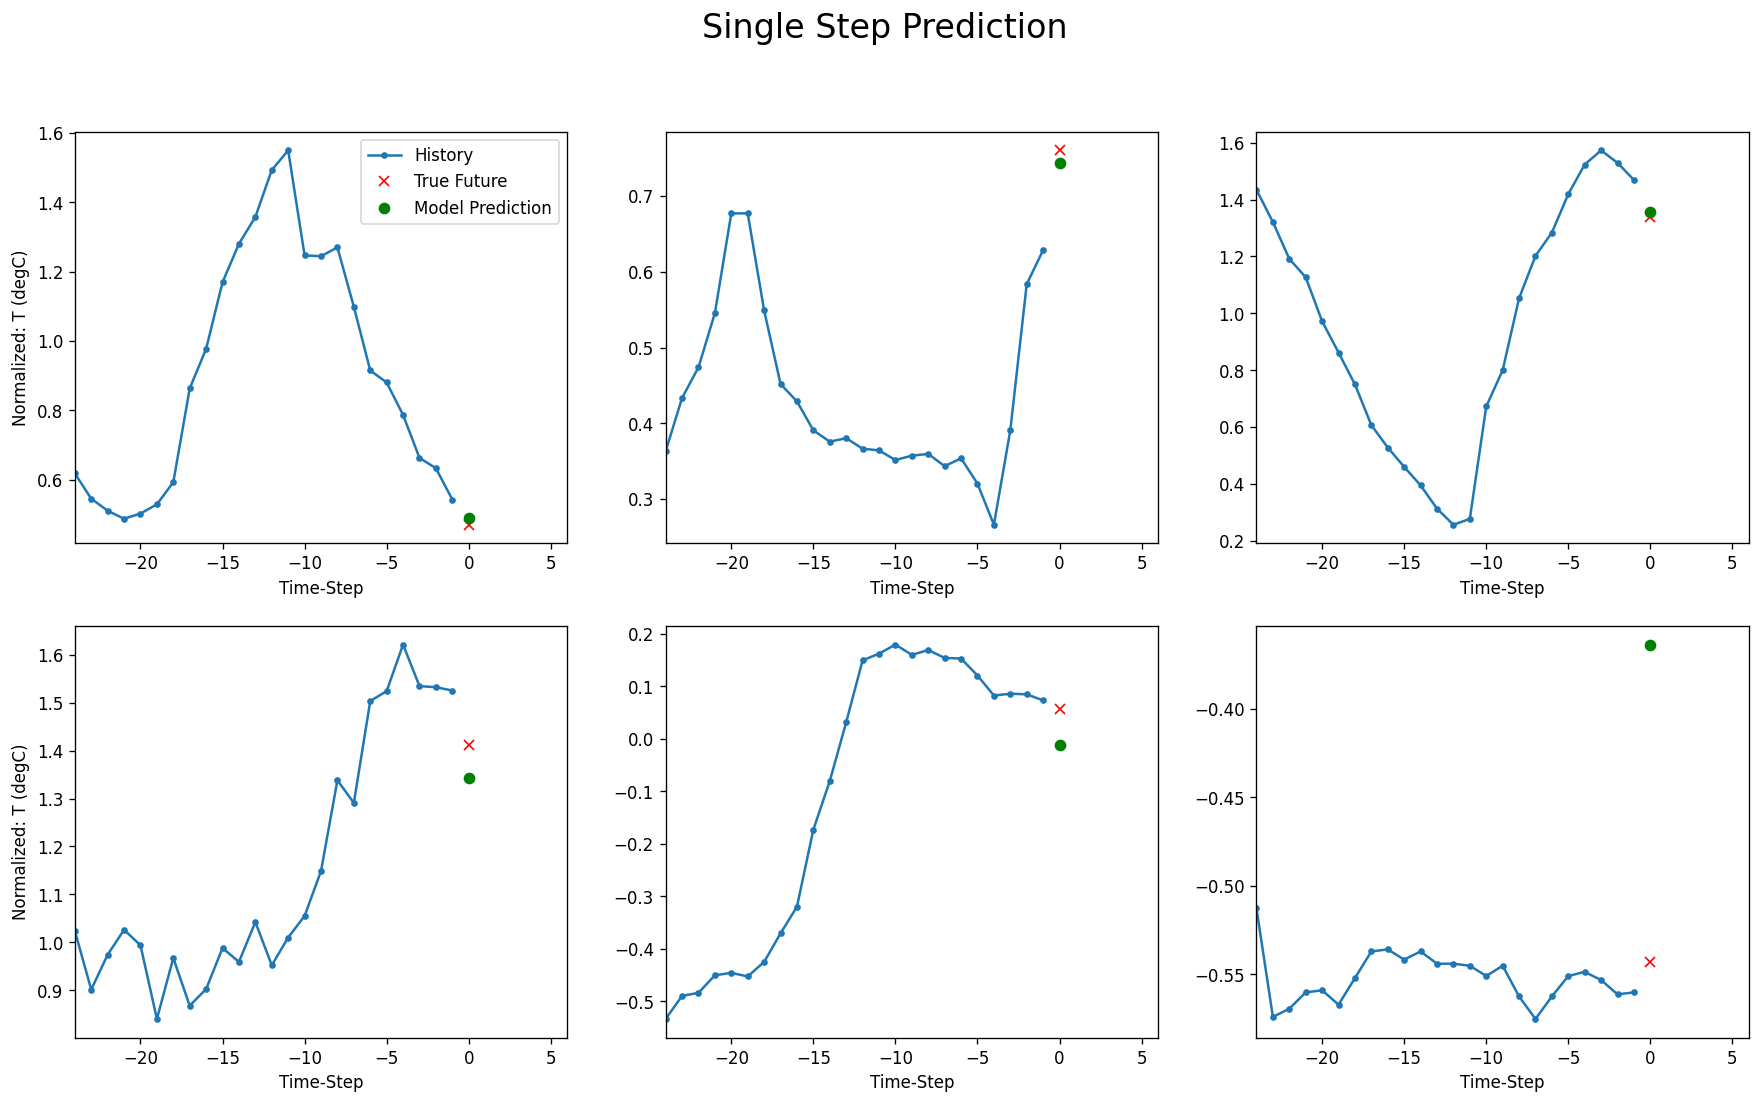

In [145]:
# define a plot function to show how well it is prediction
def show_plot(input_data:np.ndarray,target_data:np.ndarray,predictions:np.ndarray=None, delta:int=1, legend:bool=False,title=None, axs:plt.Axes=None):
    labels = ["History", "True Future", "Model Prediction"]
    multi = len(target_data.shape) > 1
    marker = [".-", "r-x" if multi else "rx"]
    input_steps = list(range(-(input_data.shape[0]), 0))
    target_steps = list(range(delta-1,delta+target_data.shape[0]-1))

    if delta:
        future = delta
    else:
        future = 0
    if axs is None:
        fig, axs = plt.subplots(figsize=(12, 6),dpi=100)
    axs.plot(input_steps,input_data, marker[0], label=labels[0])
    axs.plot(target_steps, target_data, marker[1], label=labels[1])
    if predictions is not None:
        pred_marker = "g-o" if len(predictions) > 1 else "go"
        axs.plot(target_steps, predictions, pred_marker, label=labels[2])
    if legend:
        axs.legend()
    if title is not None:
        axs.set_title(title)
    axs.set_xlim([input_steps[0], future + 5])
    axs.set_xlabel("Time-Step")
    return
def show_predictions(data:tf.data.Dataset,model:Model=None,n=6,shift:int=1,lci:list=None,input_lci:list=None):
    fig,axs = plt.subplots(nrows=2,ncols=n//2,figsize=(18,10),dpi=120)
    label_index = lci[TEMP_KEY] if lci is not None else 0
    input_index = input_lci[TEMP_KEY] if input_lci is not None else 1
    for i,(ax, (inp, tar)) in enumerate(zip(axs.flat, data.take(n))):
        if model is not None:
            pred = model.predict(inp,verbose=0)[0]
            print(f"Prediction shape = {pred.shape}")
            if len(pred.shape) > 1 and pred.shape[-1] > 1:
                pred = pred[:,label_index]
            else:
                pred = pred[None,label_index]
            print(f"Prediction shape = {pred.shape}")
        else:
            pred = None
        print(f"Target shape = {tar.shape}")
        # if tar.shape[1] > 1:
        tar = tar[0][None,label_index]
        #     print(f"Target shape = {tar.shape}")
        # else:
        #     tar = tar[0].numpy()

        inp = inp[0][:,input_index].numpy()
        print(f"Inpurt shape = {inp.shape}, Target shape = {tar.shape}")
        show_plot(inp, tar, pred, delta=shift,legend=i==0,axs=ax)
        if i==0 or i==n//2:
            ax.set_ylabel("Normalized: T (degC)")
    multi = len(tar[0].shape) > 1
    fig.suptitle(f"{'Multi' if multi else 'Single'} Step Prediction",fontsize=20)
    plt.show()
    # Set main title
show_predictions(val_ds,lstm_model_baseline,6)

## Plot Some Results - Unnormalised
Just for fun, some code to unnormalise the predictions, and plot the difference between the true values and the predictions. But for the lab you can work in normalised space as long as you are consistent!

In [42]:
predict = lstm_model_baseline.predict(test_ds)

14/14 [==============================] - 0s 10ms/step


In [43]:
def unnorm(data, label_columns_index):
  assert len(label_columns_index) == data.shape[-1] 
  tm = train_mean.get(list(label_columns_index)).values
  ts = train_std.get(list(label_columns_index)).values
  return  data * ts + tm


In [44]:
ttt = unnorm(test_targets,label_columns_index=lci)
ttp = unnorm(predict,label_columns_index=lci)

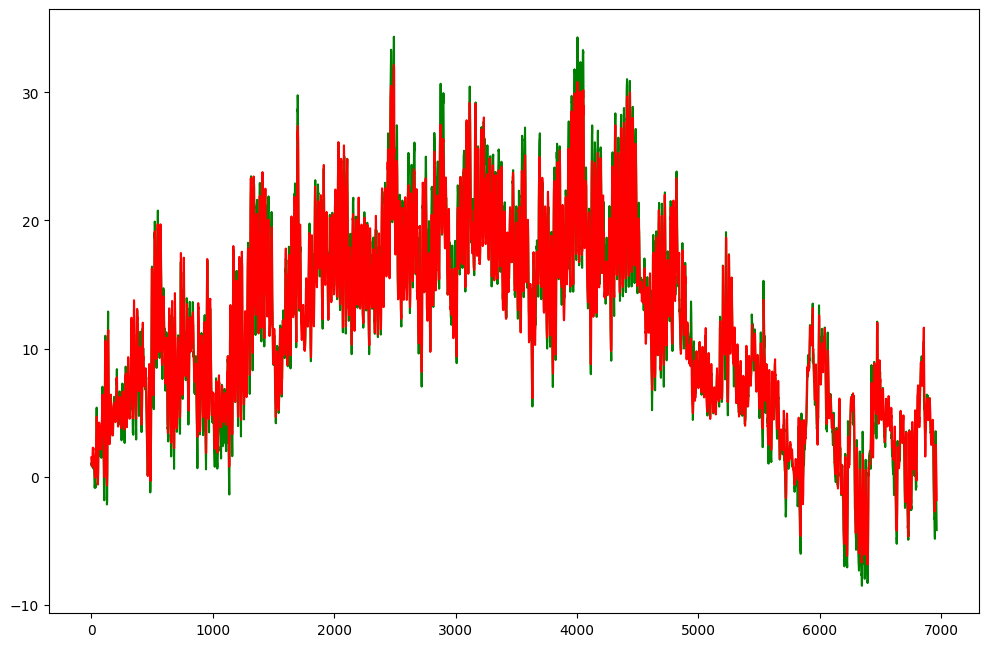

In [45]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ttt,color='g')
plt.plot(ttp, color='r')

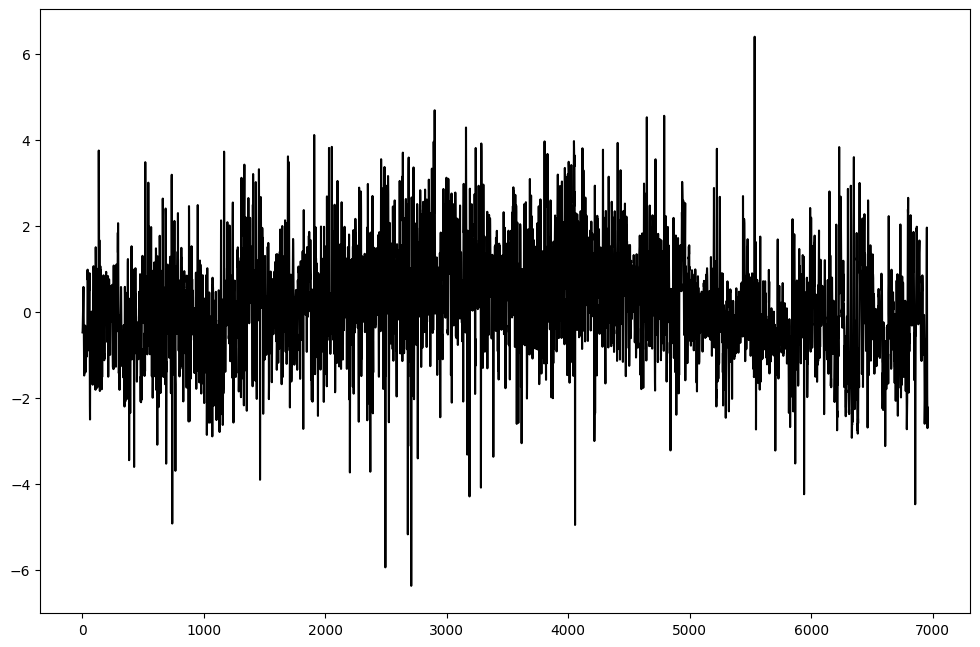

In [46]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ttt-ttp,color='k')


## Uppgift - baseline
För att ha något att jämföra med så skulle vi behöva räkna ut en "baseline". En vanlig och enkel baseline är att bara "prediktera" nästa värde att vara samma som nuvarande värde (detta är ganska rimligt för väderprediktion).

* Räkna ut en baseline med samma förlustfunktion som du bestämt dig för att använda i denna laboration.
* Var den enkla LSTM-modellen ovan bättre eller sämre än din baseline?

In [47]:
# Baseline calculation
indexes = [*input_lci.values()]

def same_model()->Model:
    x = Input(input_shape)
    y = tf.gather(x[:,-1,:],indexes,axis=-1)
    model = Model(inputs=x,outputs=y)
    return model
baseline_model = same_model()
# Compile and fit not neccessary.
baseline_history, baseline_model = compile_and_fit(baseline_model,train_ds=train_ds,val_ds=val_ds)

Epoch 1/5
22/96 [=====>........................] - ETA: 0s - loss: 0.0130 - last_time_step_mse: 0.0130

2023-05-03 09:03:30.070129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


96/96 [==============================] - 1s 11ms/step - loss: 0.0140 - last_time_step_mse: 0.0140 - val_loss: 0.0128 - val_last_time_step_mse: 0.0127 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0140 - last_time_step_mse: 0.0140 - val_loss: 0.0128 - val_last_time_step_mse: 0.0127 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0140 - last_time_step_mse: 0.0140 - val_loss: 0.0128 - val_last_time_step_mse: 0.0127 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0140 - last_time_step_mse: 0.0140 - val_loss: 0.0128 - val_last_time_step_mse: 0.0127 - lr: 5.0000e-04
Epoch 5/5
96/96 [==============================] - 1s 11ms/step - loss: 0.0140 - last_time_step_mse: 0.0140 - val_loss: 0.0128 - val_last_time_step_mse: 0.0127 - lr: 5.0000e-04


In [48]:

baseline_loss, baseline_acc = baseline_model.evaluate(test_ds)
print("Test results:", baseline_loss)

14/14 [==============================] - 0s 10ms/step - loss: 0.0142 - last_time_step_mse: 0.0139
Test results: 0.014176770113408566


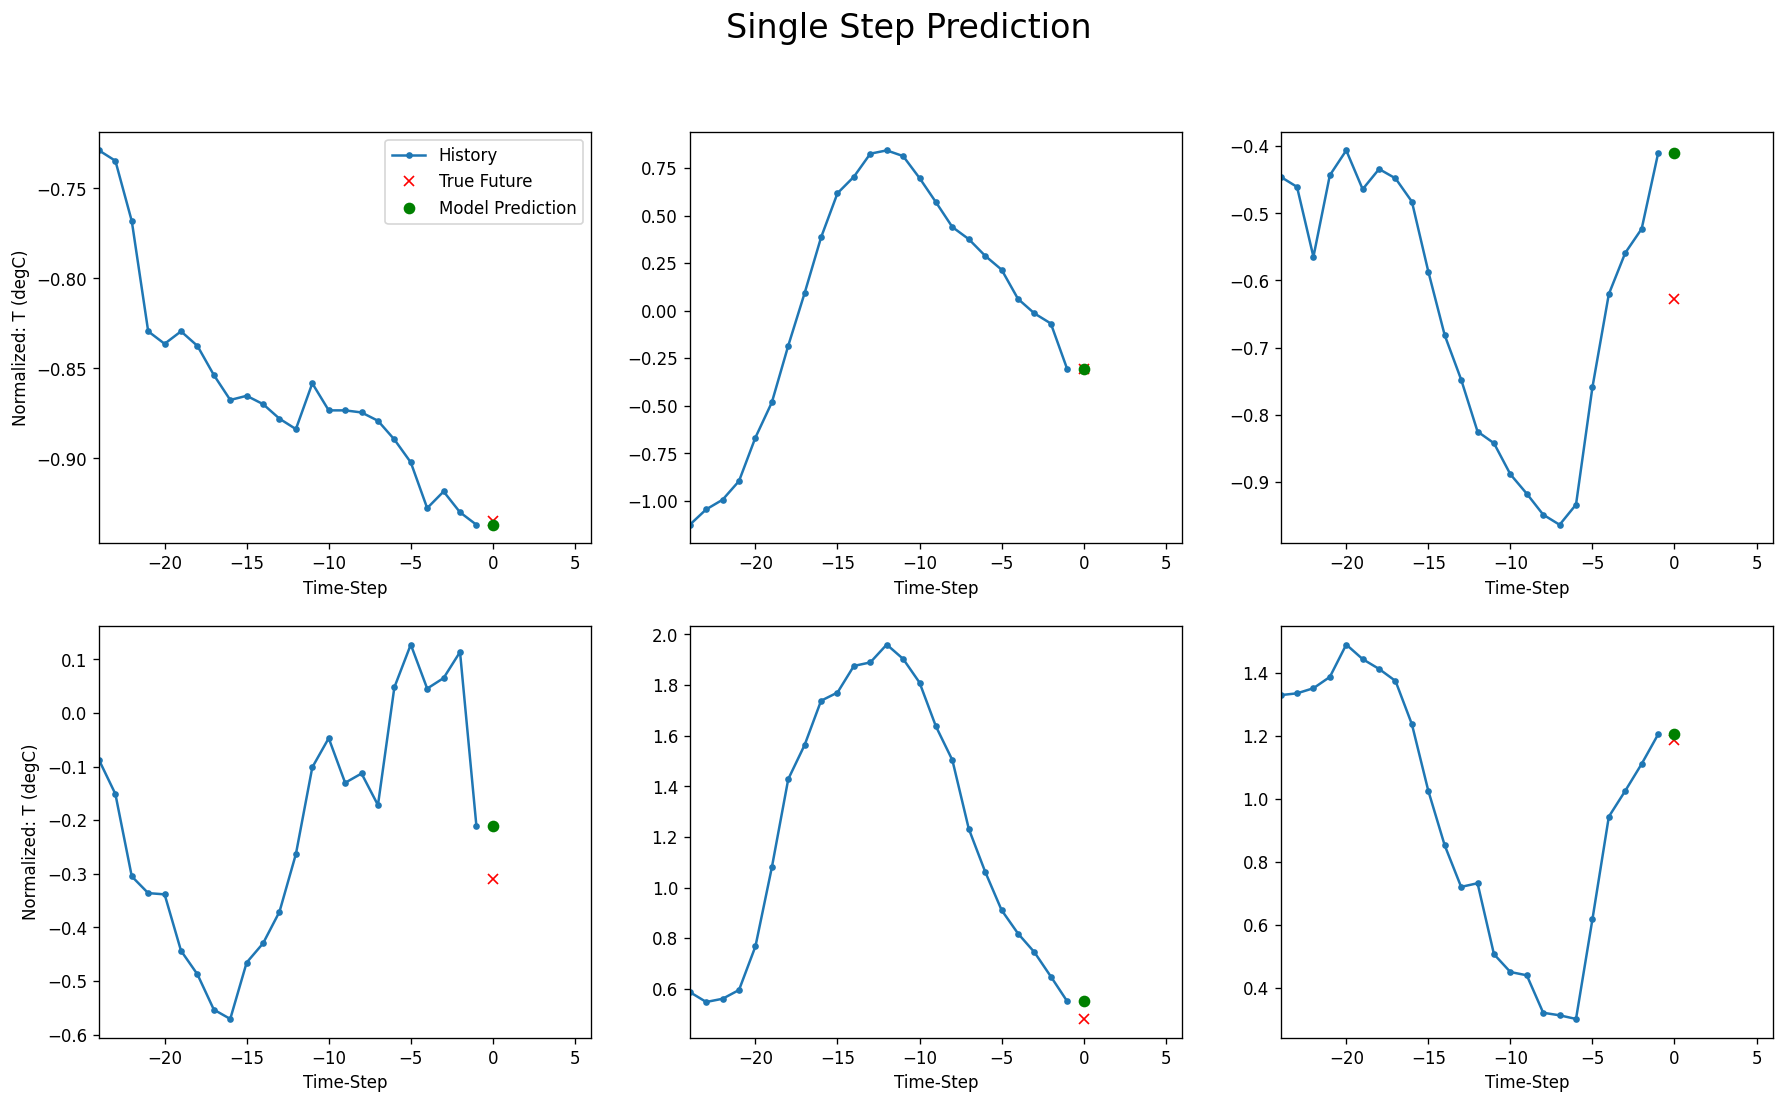

In [50]:
show_predictions(test_ds,baseline_model,6)

## Uppgift - En bättre LSTM-modell
Nästa steg är att hitta en förbättrad LSTM-modell för fallet när man vill prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input. Notera att det kan vara svårt att slå baseline för just detta problem och data, men försök.

Du kan pröva med fler noder i ditt lager eller lägga till fler lager. Notera att man INTE bör använda activation='relu' för LSTM-modeller då dessa modellerna inte kan köras på GPU:n i så fall. Om du lägger till flera lager så vill du nog ange "return_sequences=True" till alla lager utom det sista.

Pröva att använda någon av de de regulariseringsmetoder som finns tillgängliga för RNN och se ifall du på så sätt kan förbättra din modell (detta ska vara regularisering av LSTM lagren, inte t.ex. dropout mellan lagren). Argumentera för dina val av regularisering och diskutera dina resultat. Notera även ifall någon av regulariseringarna du testat tvingar modellen till CPU:n istället för GPU:n.

Beskrivning av vilka parametrar som styr regulariseringen i LSTM finns här: https://keras.io/api/layers/recurrent_layers/lstm/
(kernel_regularizer, recurrent_regularizer, bias_regularizer, activity_regularizer, dropout, recurrent_dropout). Man får dock kanske se upp om man vill använda cuDNN, dvs vissa GPU implementeringar, för de verkar tyvärr kräva att “recurrent_dropout == 0”.

Att vanlig dropout kanske inte är så bra finns först beskrivet i följande papper:
Zaremba, W., Sutskever, I., & Vinyals, O. (2014). Recurrent neural network regularization. arXiv preprint arXiv:1409.2329

**Analysera dina resultat och jämför de olika modellerna.**


In [51]:
def fit_and_evaluate_model(model:Model,train_ds,val_ds,test_ds,patience=5,shift:int=1,lci:list=None,input_lci:list=None):
    label_index = lci[TEMP_KEY] if lci is not None else 0
    input_index = input_lci[TEMP_KEY] if input_lci is not None else 1
    print(f"Label index: {label_index}, Input index: {input_index}")
    history, model = compile_and_fit(model,train_ds=train_ds,val_ds=val_ds,patience=patience,label_metric_index=label_index)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print('Test Loss: %.3f' % test_loss)
    print('Test Metric: %.3f' % test_acc)
    # Plot the training curves
    
    df = pd.DataFrame(history.history)
    df.pop('lr') #
    df.plot(figsize=(12,8))
    plt.show()
    show_predictions(model=model,data=test_ds,n=6,shift=shift,lci=lci,input_lci=input_lci)
    return history, model, test_loss, test_acc

Label index: 0, Input index: 1
Epoch 1/5
96/96 [==============================] - 5s 25ms/step - loss: 0.2466 - last_time_step_mse: 0.2464 - val_loss: 0.0963 - val_last_time_step_mse: 0.0975 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1286 - last_time_step_mse: 0.1286 - val_loss: 0.2827 - val_last_time_step_mse: 0.2834 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1674 - last_time_step_mse: 0.1674 - val_loss: 0.0625 - val_last_time_step_mse: 0.0620 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 2s 16ms/step - loss: 0.0659 - last_time_step_mse: 0.0659 - val_loss: 0.0271 - val_last_time_step_mse: 0.0268 - lr: 0.0010
Epoch 5/5
96/96 [==============================] - 2s 16ms/step - loss: 0.0808 - last_time_step_mse: 0.0807 - val_loss: 0.0277 - val_last_time_step_mse: 0.0278 - lr: 0.0010
Test Loss: 0.024
Test Metric: 0.024


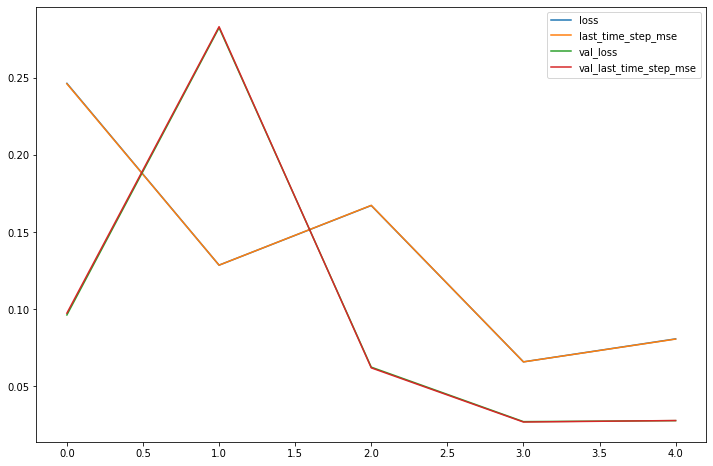

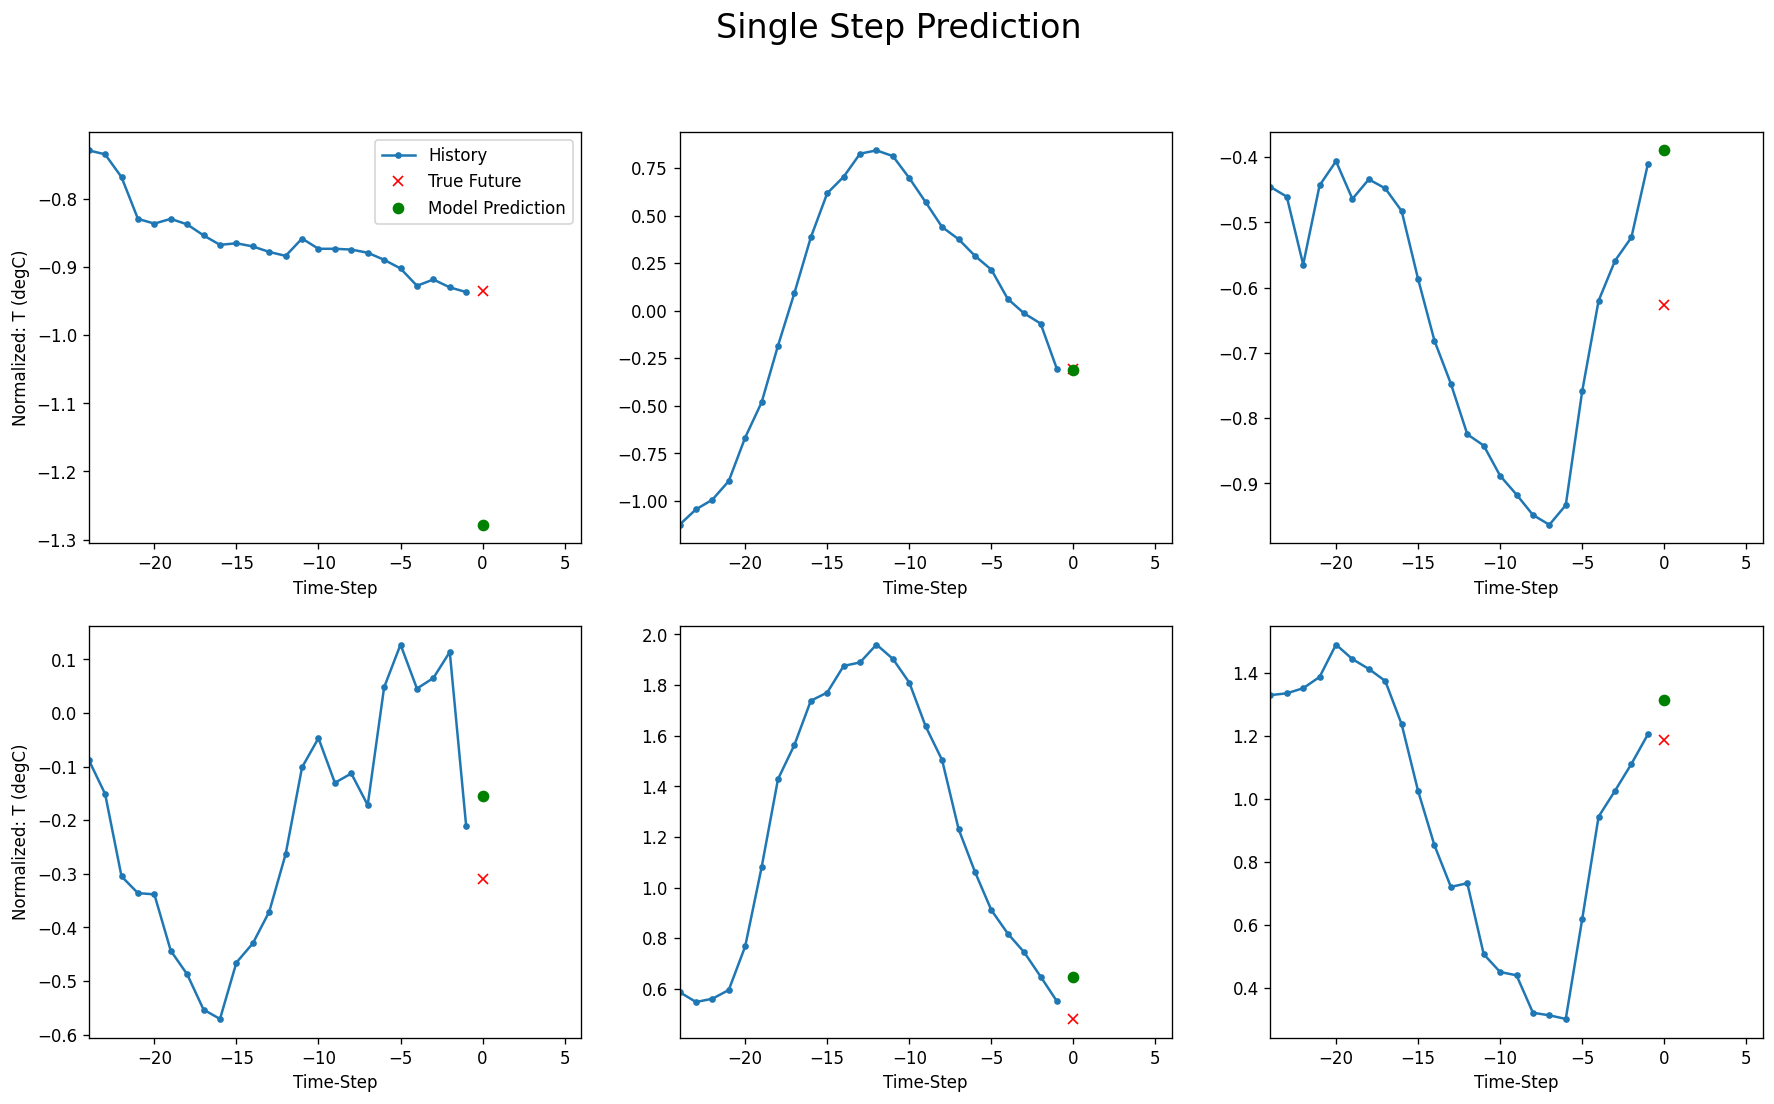

In [52]:
# Better LSTM model(s): definition, compile and run, evaluate, and compare!
def lstm_model(n_output_steps:int=1)->Model:
    inputs = Input(input_shape)
    # Shape [batch, time, features] => [batch, time, gru_units]
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(512, return_sequences=False)(x)
    # Shape => [batch, time, gru_units] => [batch, output_steps*output_features]
    x = Dense(n_output_steps*num_target_features,activation='linear')(x)
    # Shape => [batch, output_steps, output_features]
    if num_target_features > 1:
        y = Reshape([n_output_steps,num_target_features])(x)
    else:
        y = Reshape([n_output_steps])(x)
    model = Model(inputs=inputs,outputs=y)
    return model
better_lstm = lstm_model()

# Compile and train this model
better_lstm_history, better_lstm, better_lstm_test_loss, better_lstm_test_acc = fit_and_evaluate_model(better_lstm,train_ds,val_ds,test_ds)

## Uppgift - GRU
Pröva även med att ersätta LSTM med GRU (en annan RNN modell) med samma antal noder och lager som för din bästa LSTM modell. Finner du någon skillnad i prestanda, konvergens, tidsåtgång vid träning, eller annat? 

In [53]:
# An GRU model: definition, compile and run, evaluate, and compare!
def gru_model(n_output_steps:int=1)->Model:
    inputs = Input(input_shape)
    # Shape [batch, time, features] => [batch, time, gru_units]
    x = GRU(128, return_sequences=True)(inputs)
    x = GRU(256, return_sequences=True)(x)
    x = GRU(512, return_sequences=False)(x)
    # Shape => [batch, time, gru_units] => [batch, output_steps*output_features]
    x = Dense(n_output_steps*num_target_features,activation='linear')(x)
    # Shape => [batch, output_steps, output_features]
    if num_target_features > 1:
        y = Reshape([n_output_steps,num_target_features])(x)
    else:
        y = Reshape([n_output_steps])(x)
    model = Model(inputs=inputs,outputs=y)
    return model

In [54]:
better_gru = gru_model(n_output_steps=1)
better_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 gru (GRU)                   (None, 24, 128)           57216     
                                                                 
 gru_1 (GRU)                 (None, 24, 256)           296448    
                                                                 
 gru_2 (GRU)                 (None, 512)               1182720   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
 reshape_1 (Reshape)         (None, 1)                 0         
                                                                 
Total params: 1,536,897
Trainable params: 1,536,897
Non-tra

Label index: 0, Input index: 1
Epoch 1/5
96/96 [==============================] - 4s 21ms/step - loss: 0.1363 - last_time_step_mse: 0.1360 - val_loss: 0.0373 - val_last_time_step_mse: 0.0371 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 1s 14ms/step - loss: 0.0696 - last_time_step_mse: 0.0695 - val_loss: 0.1323 - val_last_time_step_mse: 0.1336 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 1s 15ms/step - loss: 0.0808 - last_time_step_mse: 0.0807 - val_loss: 0.0155 - val_last_time_step_mse: 0.0153 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 1s 15ms/step - loss: 0.0344 - last_time_step_mse: 0.0343 - val_loss: 0.0515 - val_last_time_step_mse: 0.0513 - lr: 0.0010
Epoch 5/5
96/96 [==============================] - 1s 15ms/step - loss: 0.0424 - last_time_step_mse: 0.0423 - val_loss: 0.0616 - val_last_time_step_mse: 0.0624 - lr: 0.0010
Test Loss: 0.046
Test Metric: 0.048


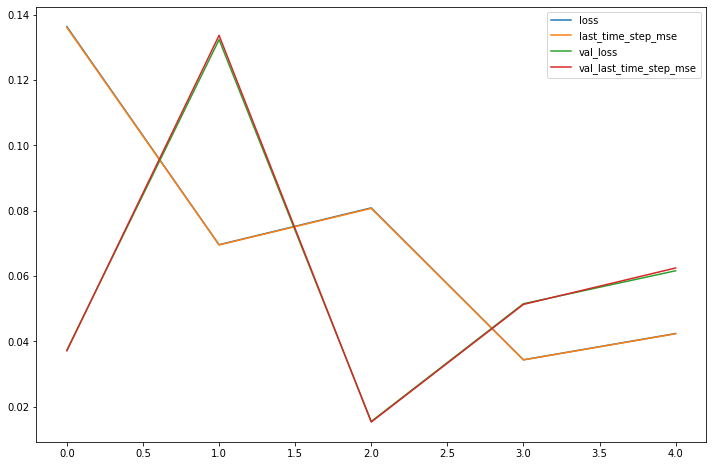

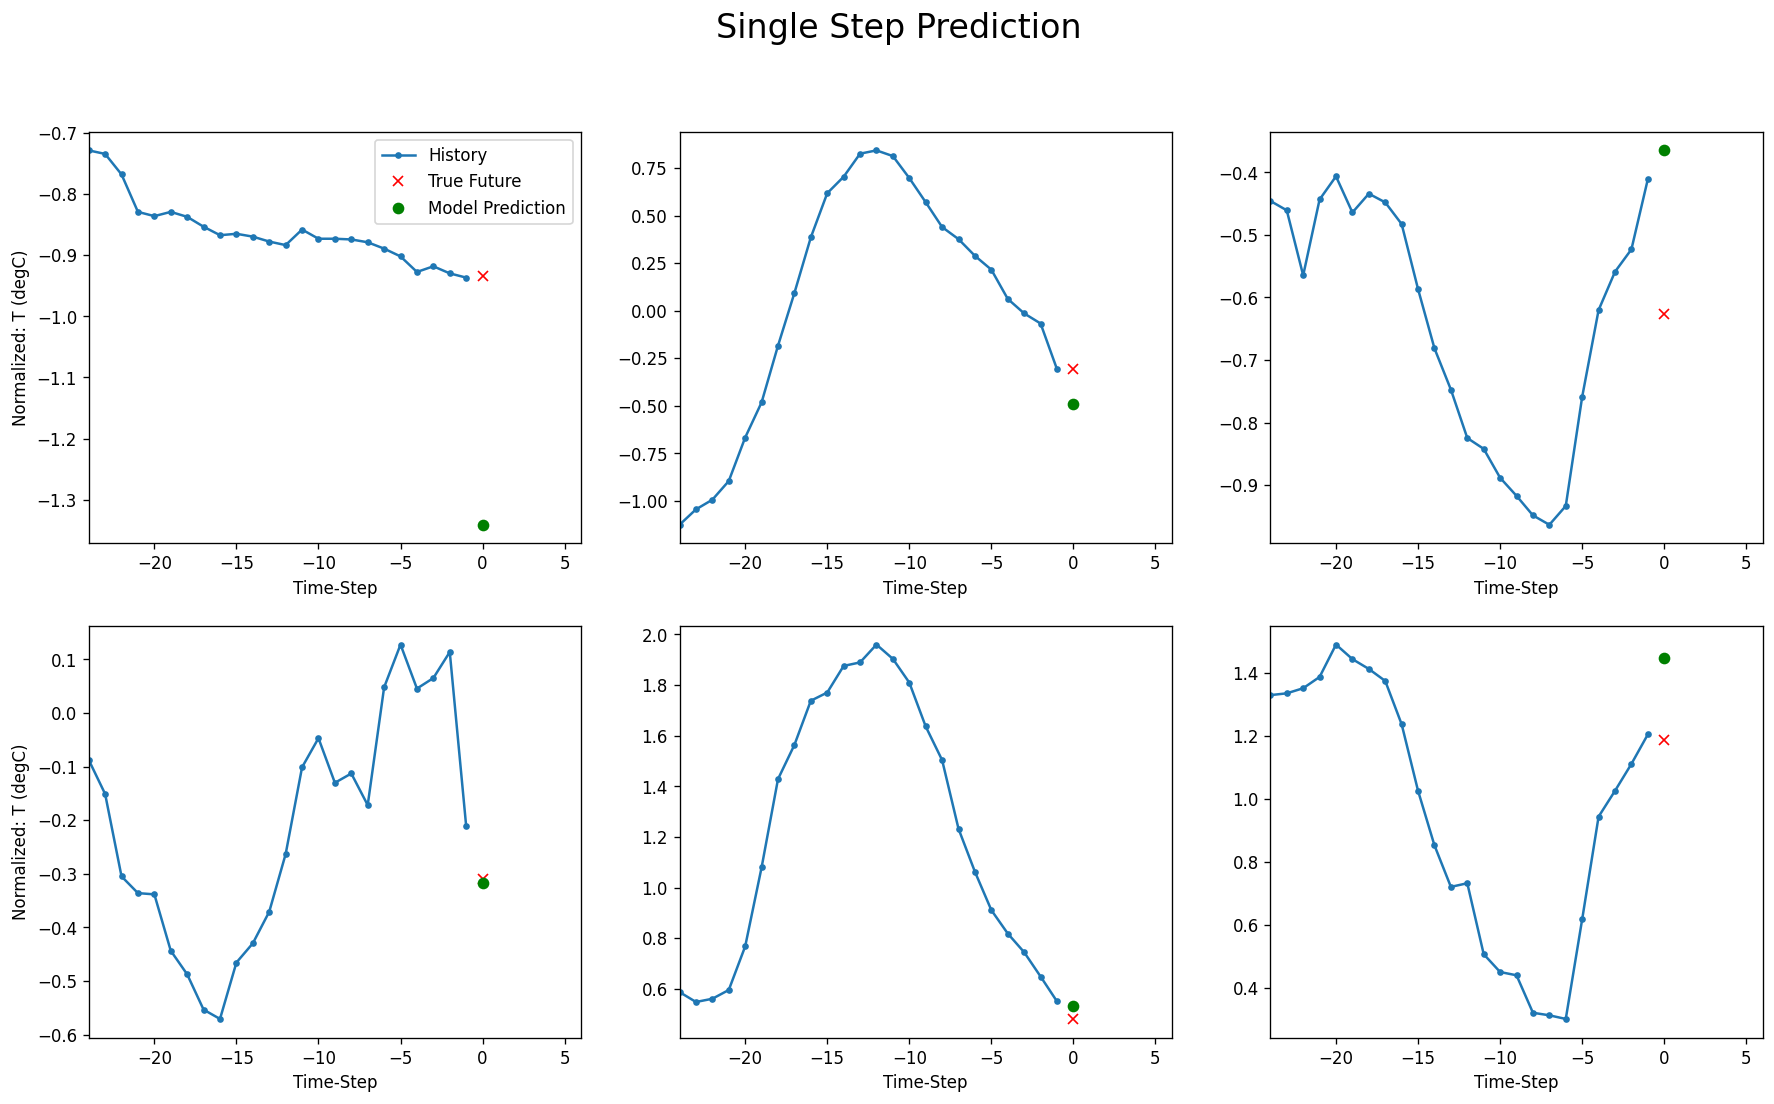

In [55]:
better_gru_history, better_gru, better_gru_test_loss, better_gru_test_acc = fit_and_evaluate_model(better_gru,train_ds,val_ds,test_ds)

# Del 2:  Prediktera flera steg framåt
I del 2 ska du göra två olika modeller som båda ska prediktera vad temperaturen är 24 timmar framåt, baserat på de senaste 24 timmarnas mätvärden. D.v.s om din input-sekvens t.ex. löper från timme 1 till och med timme 24, så ska du prediktera vad temperaturen är vid timme 48.

## Uppgift 24-timmar framåt med "direkt prediktion"
Del 2.1. Direkt-prediktion av det värdet du söker (single-step with a new target time-step). D.v.s använd 24 timmars input-värden för att endast prediktera ett utvärde. 24 timmar framåt (timme 48).

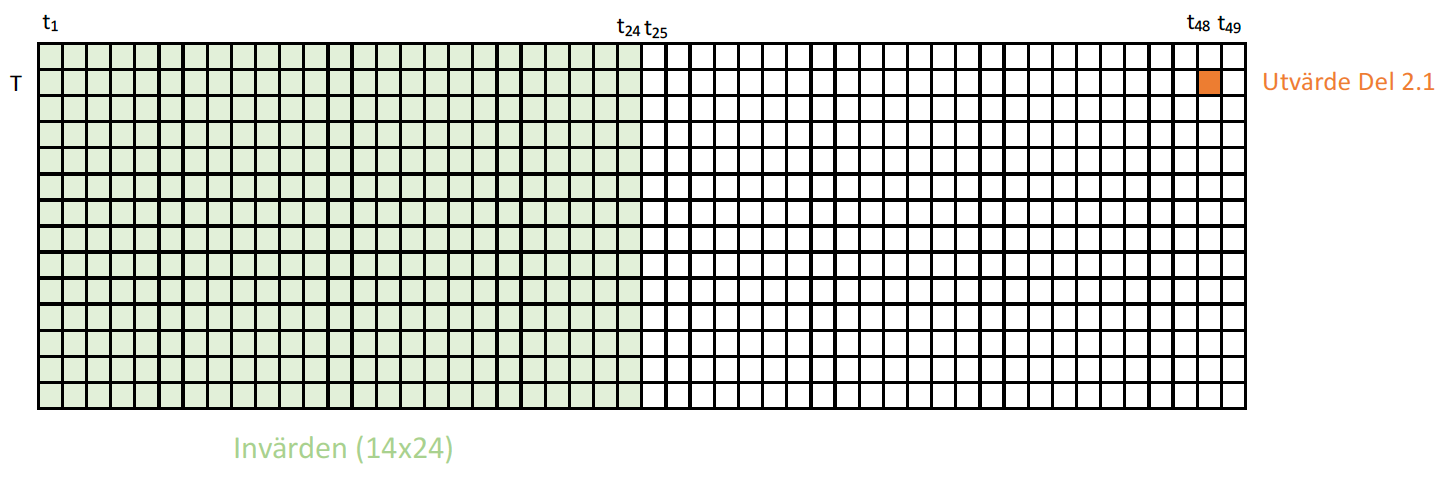

Number of samples: 96
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 28
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 14
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 1)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Label index: 0, Input index: 1
Epoch 1/5
96/96 [==============================] - 5s 20ms/step - loss: 0.2561 - last_time_step_mse: 0.2559 - val_loss: 0.1537 - val_last_time_step_mse: 0.1525 - lr: 0.0010
Epoch 2/5
96/96 [==========================

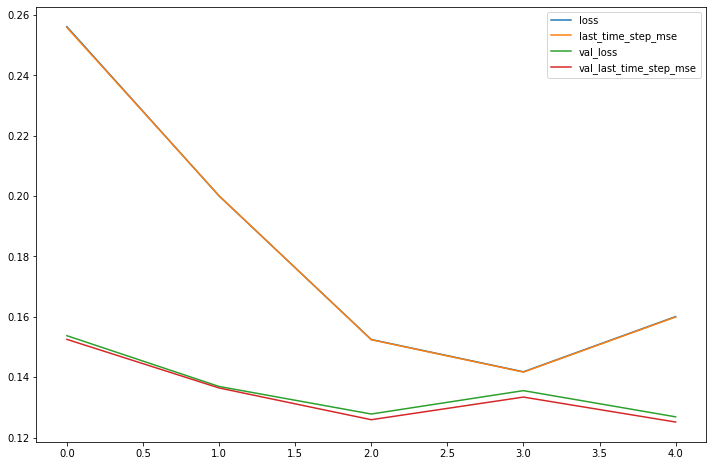

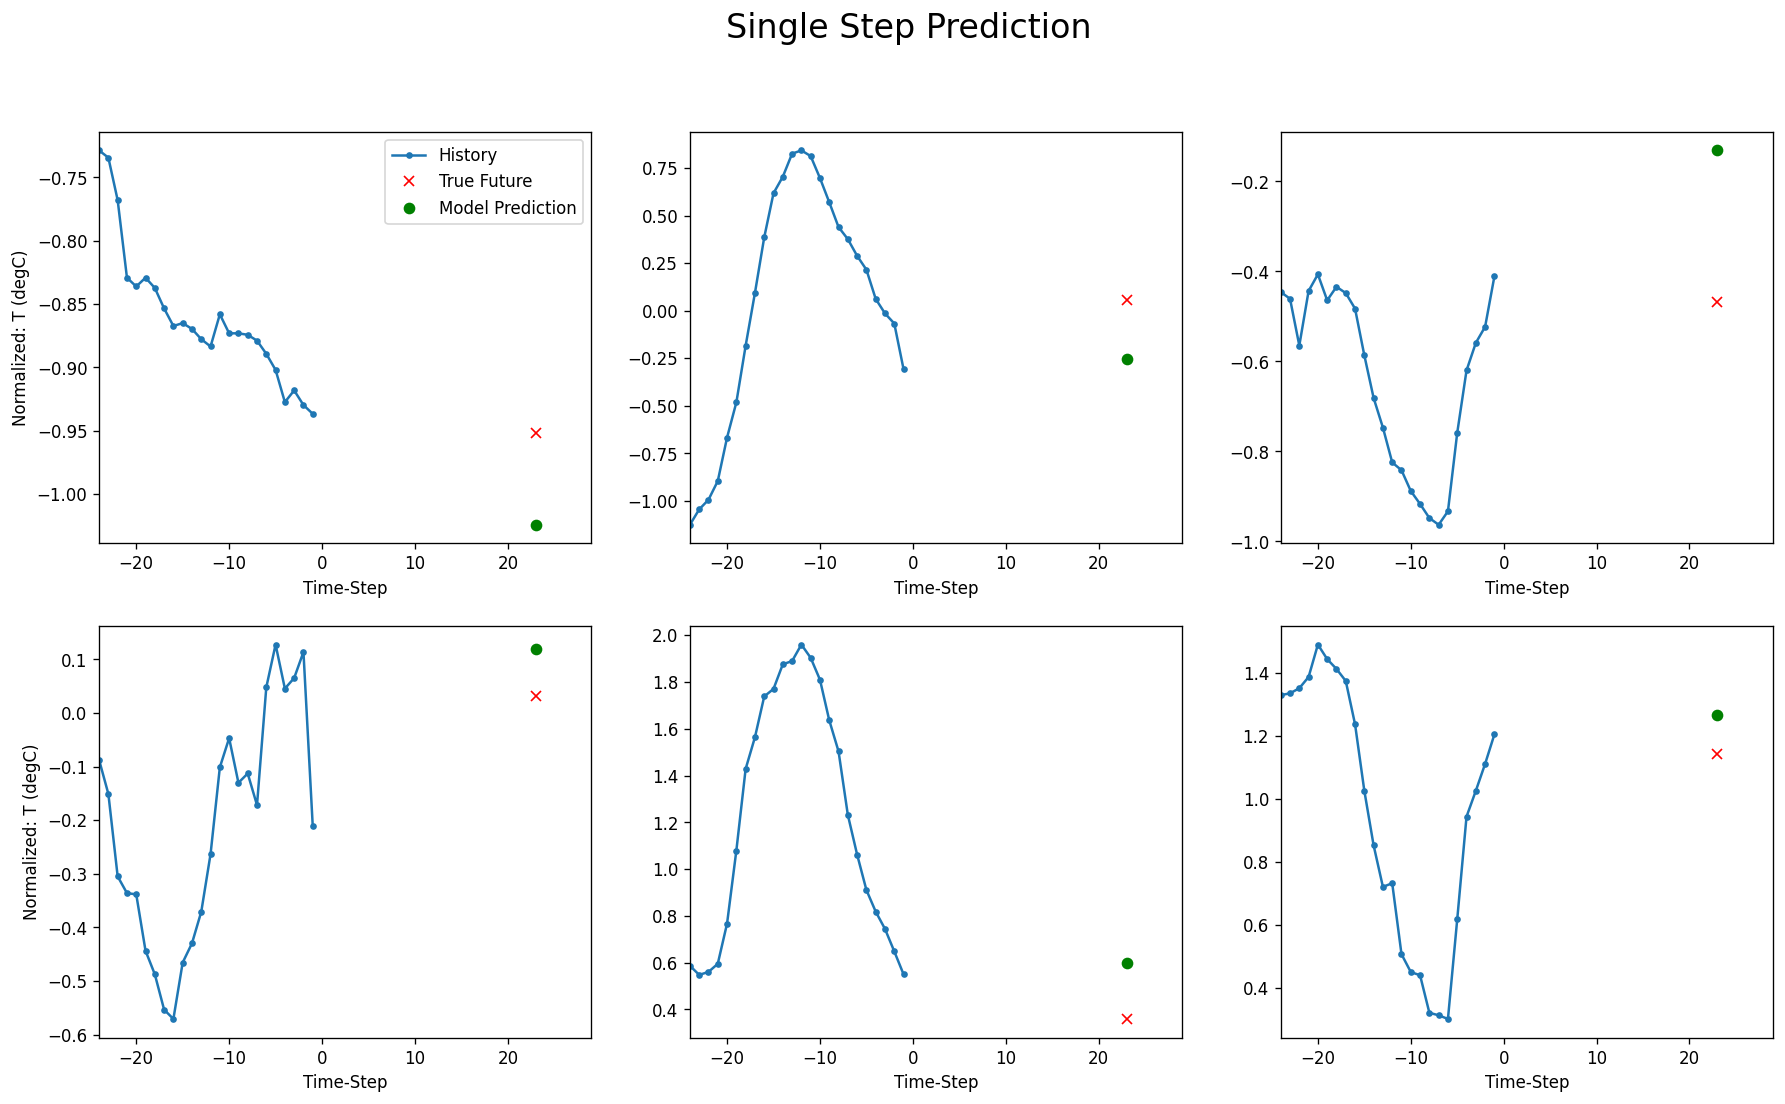

In [56]:
shift = 24
label_width = 1
train_ds_shift_24, val_ds_shift_24, test_ds_shift24 = train_val_test(shift=shift, n_outputs=label_width)
# A good GRU model from above but predict at 48 instead of 24
gru_24 = gru_model(label_width)
gru_24_history, gru_24, model_24_test_loss, gru_24_test_acc = fit_and_evaluate_model(gru_24, train_ds_shift_24, val_ds_shift_24, test_ds_shift24,shift=shift)

## Uppgift 24-timmar framåt med "mellanliggande prediktioner"
Del 2.2. Gör en prediktion av alla mellanliggande värden också. D.v.s använd återigen 24 timmars input-värden, men prediktera alla värden från timme 25 till och med timme 48. Din output blir nu en 24 värden lång vektor vid varje prediktion. 

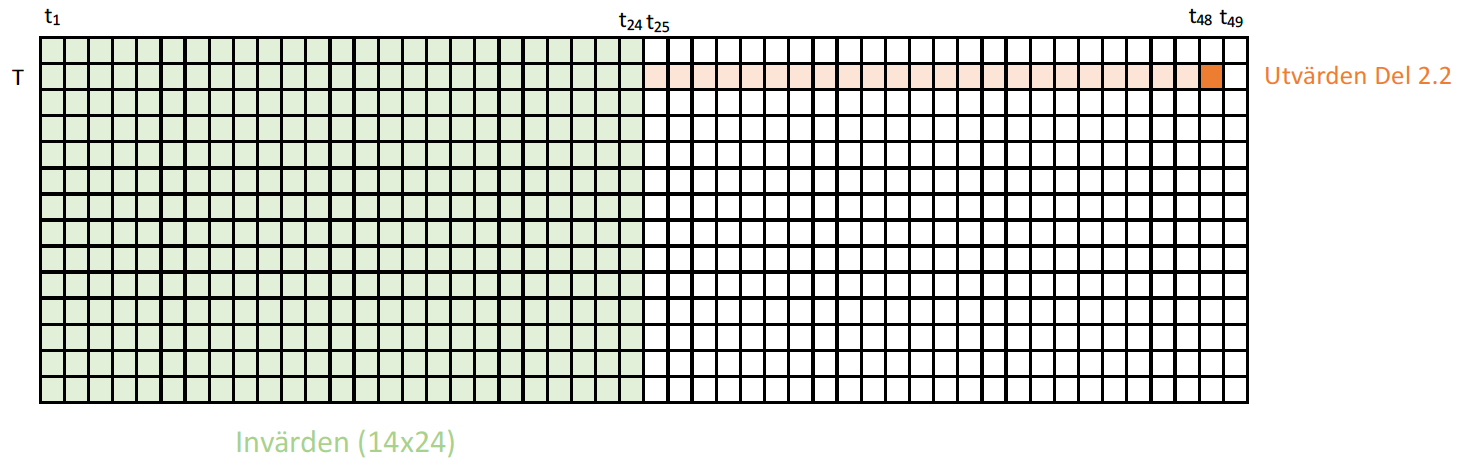

Notera att vi för dessa två modeller endast är intresserad av kvalitén av prediktionen vid timme 48, så du behöver hitta ett sätt att mäta prestationen för just denna timme för att kunna jämföra modellerna mot modell 2.1 och sinsemellan.

Du kan mäta felet på två sätt, antingen “manuellt” plocka ut målvärdena och prediktionen (sista värdet) för testdatat och och sedan beräkna felet enligt den metod du valt. Alternativt kan man skapa en “custom metric” (kapitel 12, s416), men du får eventuellt göra om från MSE till det mått du valt.

```
def last_time_step_mse(Y_true, Y_pred):
   return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
```




## Create a multi label timeseries dataset
Använder referens kod från dokumentationen av [tf.keras.utils.timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) och [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

<details open markdown="1" title="Reference Multi Label Timeseries Dataset">


### Reference Multi Label Timeseries Dataset:
```python
X = np.arange(100)
Y = X*2

sample_length = 20
input_dataset = tf.keras.utils.timeseries_dataset_from_array(
  X, None, sequence_length=sample_length, sequence_stride=sample_length)
target_dataset = tf.keras.utils.timeseries_dataset_from_array(
  Y, None, sequence_length=sample_length, sequence_stride=sample_length)

for batch in zip(input_dataset, target_dataset):
  inputs, targets = batch
  assert np.array_equal(inputs[0], X[:sample_length])

  # second sample equals output timestamps 20-40
  assert np.array_equal(targets[1], Y[sample_length:2*sample_length])
  break
```

### Reference Zipped Dataset:
```python
# The nested structure of the `datasets` argument determines the
# structure of elements in the resulting dataset.
a = tf.data.Dataset.range(1, 4)  # ==> [ 1, 2, 3 ]
b = tf.data.Dataset.range(4, 7)  # ==> [ 4, 5, 6 ]
ds = tf.data.Dataset.zip((a, b))
list(ds.as_numpy_iterator())

ds = tf.data.Dataset.zip((b, a))
list(ds.as_numpy_iterator())


# The `datasets` argument may contain an arbitrary number of datasets.
c = tf.data.Dataset.range(7, 13).batch(2)  # ==> [ [7, 8],
                                           #       [9, 10],
                                           #       [11, 12] ]
ds = tf.data.Dataset.zip((a, b, c))
for element in ds.as_numpy_iterator():
  print(element)




# The number of elements in the resulting dataset is the same as
# the size of the smallest dataset in `datasets`.
d = tf.data.Dataset.range(13, 15)  # ==> [ 13, 14 ]
ds = tf.data.Dataset.zip((a, d))
list(ds.as_numpy_iterator())
```

Number of samples: 96
Input shape: (512, 24, 19)
Target shape: (512, 24, 1)
Number of samples: 28
Input shape: (512, 24, 19)
Target shape: (512, 24, 1)
Number of samples: 14
Input shape: (512, 24, 19)
Target shape: (512, 24, 1)
Inpurt shape = (24,), Target shape = (24, 1)
Inpurt shape = (24,), Target shape = (24, 1)
Inpurt shape = (24,), Target shape = (24, 1)
Inpurt shape = (24,), Target shape = (24, 1)
Inpurt shape = (24,), Target shape = (24, 1)
Inpurt shape = (24,), Target shape = (24, 1)


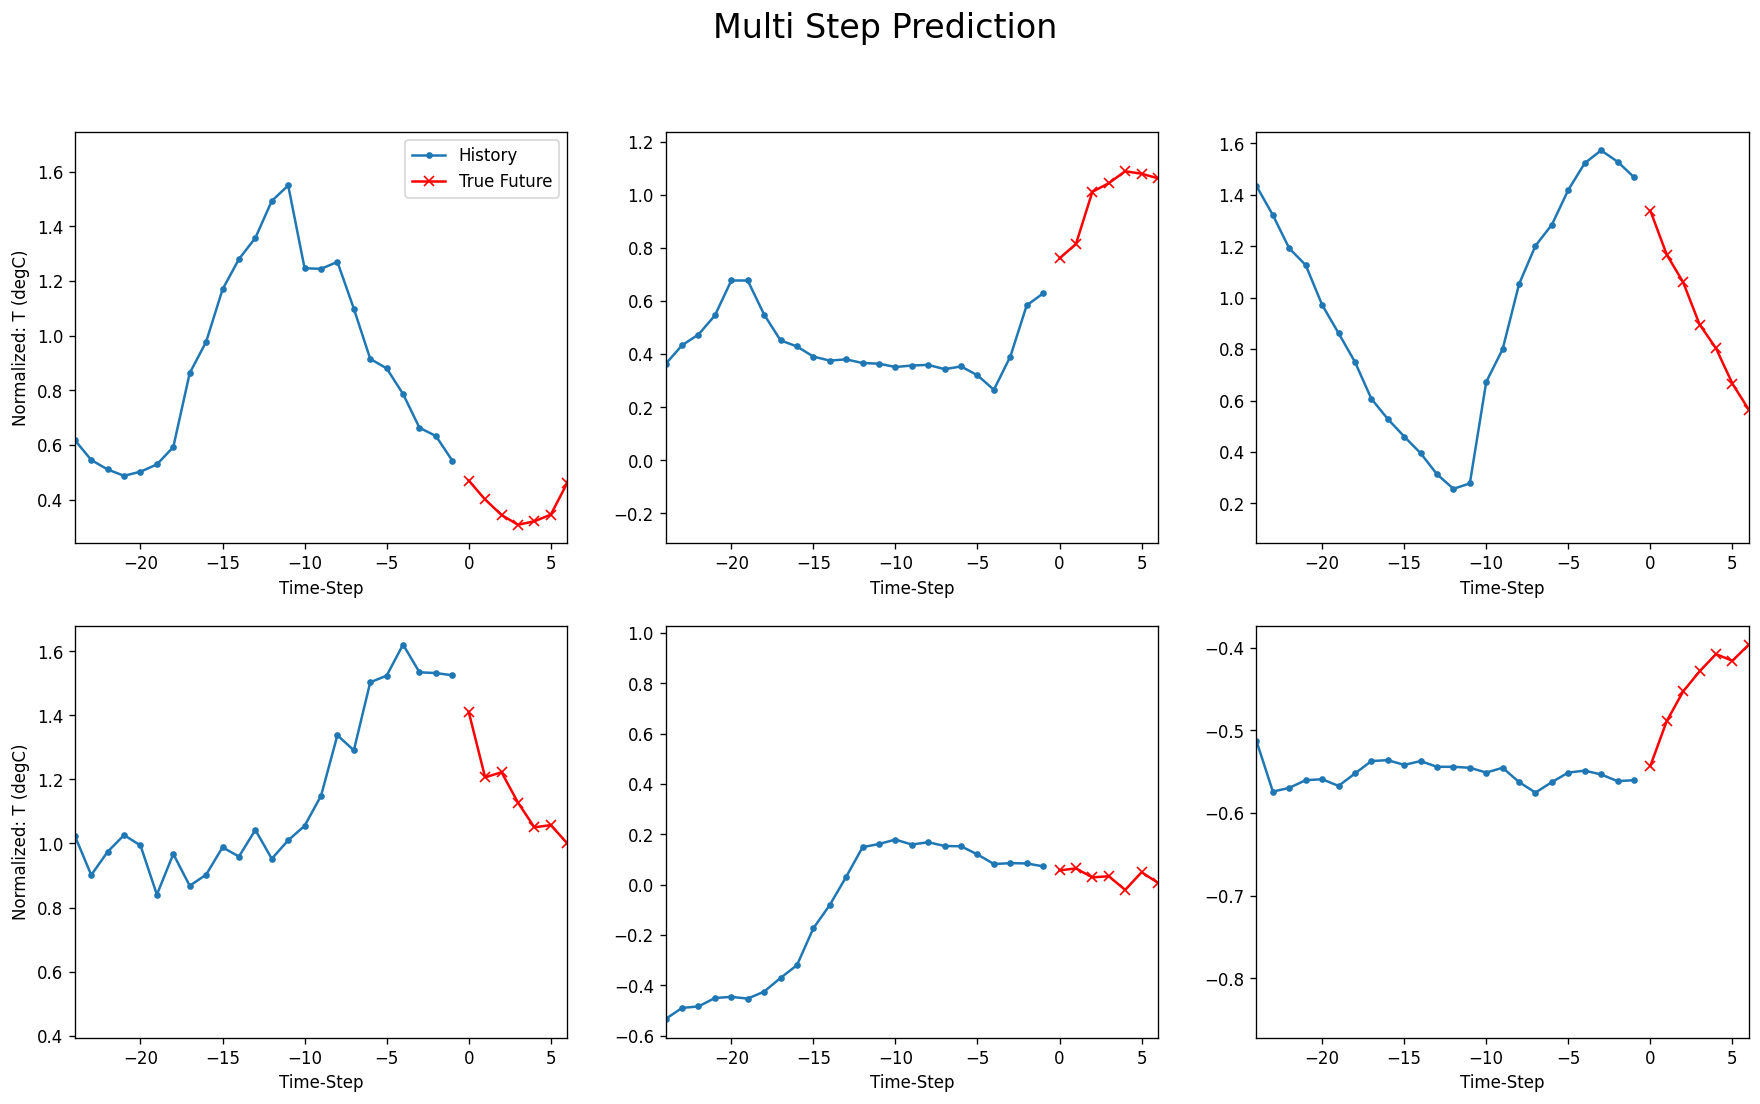

In [67]:
# Here is our function that take our time sequence data and convert it to a dataset 
# that then can be us as a dataset for training or evaluation
def datasetgen_multi(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
               label_columns=None, start_index=None, end_index=None, shuffle=False):
  offset = input_width+shift-1         # offset to where targets start (and input ends)
  input_data = dataframe[:-offset]   # Input up until where the target starts
  label_columns_indices = get_label_columns_indices(dataframe, label_columns) # get the selected columns
  targets = dataframe[list(label_columns_indices)]
  targets = targets[offset:]         # Output from end of input and for the selected columns
  # Here we create the windows and store them as a dataset using 'timesesries_dataset_from_array'
  input_ds = timeseries_dataset_from_array(
    input_data, None, sequence_length=input_width,
    sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
    start_index=start_index, end_index=end_index)
  target_ds = timeseries_dataset_from_array(
    targets, None, sequence_length=label_width,
    sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
    start_index=start_index, end_index=end_index)
  ds = tf.data.Dataset.zip((input_ds, target_ds))
  for batch in ds.take(1):
    inputs, targets = batch
    print(f"Number of samples: {len(ds)}")
    print('Input shape:', inputs.numpy().shape)
    print('Target shape:', targets.numpy().shape)
  return ds
# Now create the used datasets for part 1
lcol=['T (degC)']
input_lci = dict((k, all_lci[k]) for k in all_lci.keys() if k in lcol)
lci = get_label_columns_indices(dfnorm, lcol)
shift = 1
def train_val_test_multi(shift, n_outputs, lcol=['T (degC)']):
    train_ds = datasetgen_multi(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift, 
                label_columns=lcol, start_index=0, end_index=split1ix, batch_size=BATCH_SIZE)
    val_ds = datasetgen_multi(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift, 
                label_columns=lcol, start_index=split1ix, end_index=split2ix, batch_size=BATCH_SIZE)
    test_ds = datasetgen_multi(dfnorm, input_width=N_PREV_STEPS, label_width=n_outputs, shift=shift,
                label_columns=lcol, start_index=split2ix, end_index=None, batch_size=BATCH_SIZE)
    return train_ds, val_ds, test_ds
train_ds_24, val_ds_24, test_ds_24 = train_val_test_multi(shift, 24)
show_predictions(val_ds_24,n=6,shift=shift)


In [127]:
train_val_test_multi(1, 1)

Number of samples: 96
Input shape: (512, 24, 19)
Target shape: (512, 1, 1)
Number of samples: 28
Input shape: (512, 24, 19)
Target shape: (512, 1, 1)
Number of samples: 14
Input shape: (512, 24, 19)
Target shape: (512, 1, 1)


(<ZipDataset element_spec=(TensorSpec(shape=(None, None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>,
 <ZipDataset element_spec=(TensorSpec(shape=(None, None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>,
 <ZipDataset element_spec=(TensorSpec(shape=(None, None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>)

Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)
Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)
Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)
Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)
Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)
Prediction shape = (24,)
Target shape = (512, 24, 1)
Target shape = (24, 1)
Target shape = (24,)
Target shape = (24,)
Inpurt shape = (24,), Target shape = (24,)


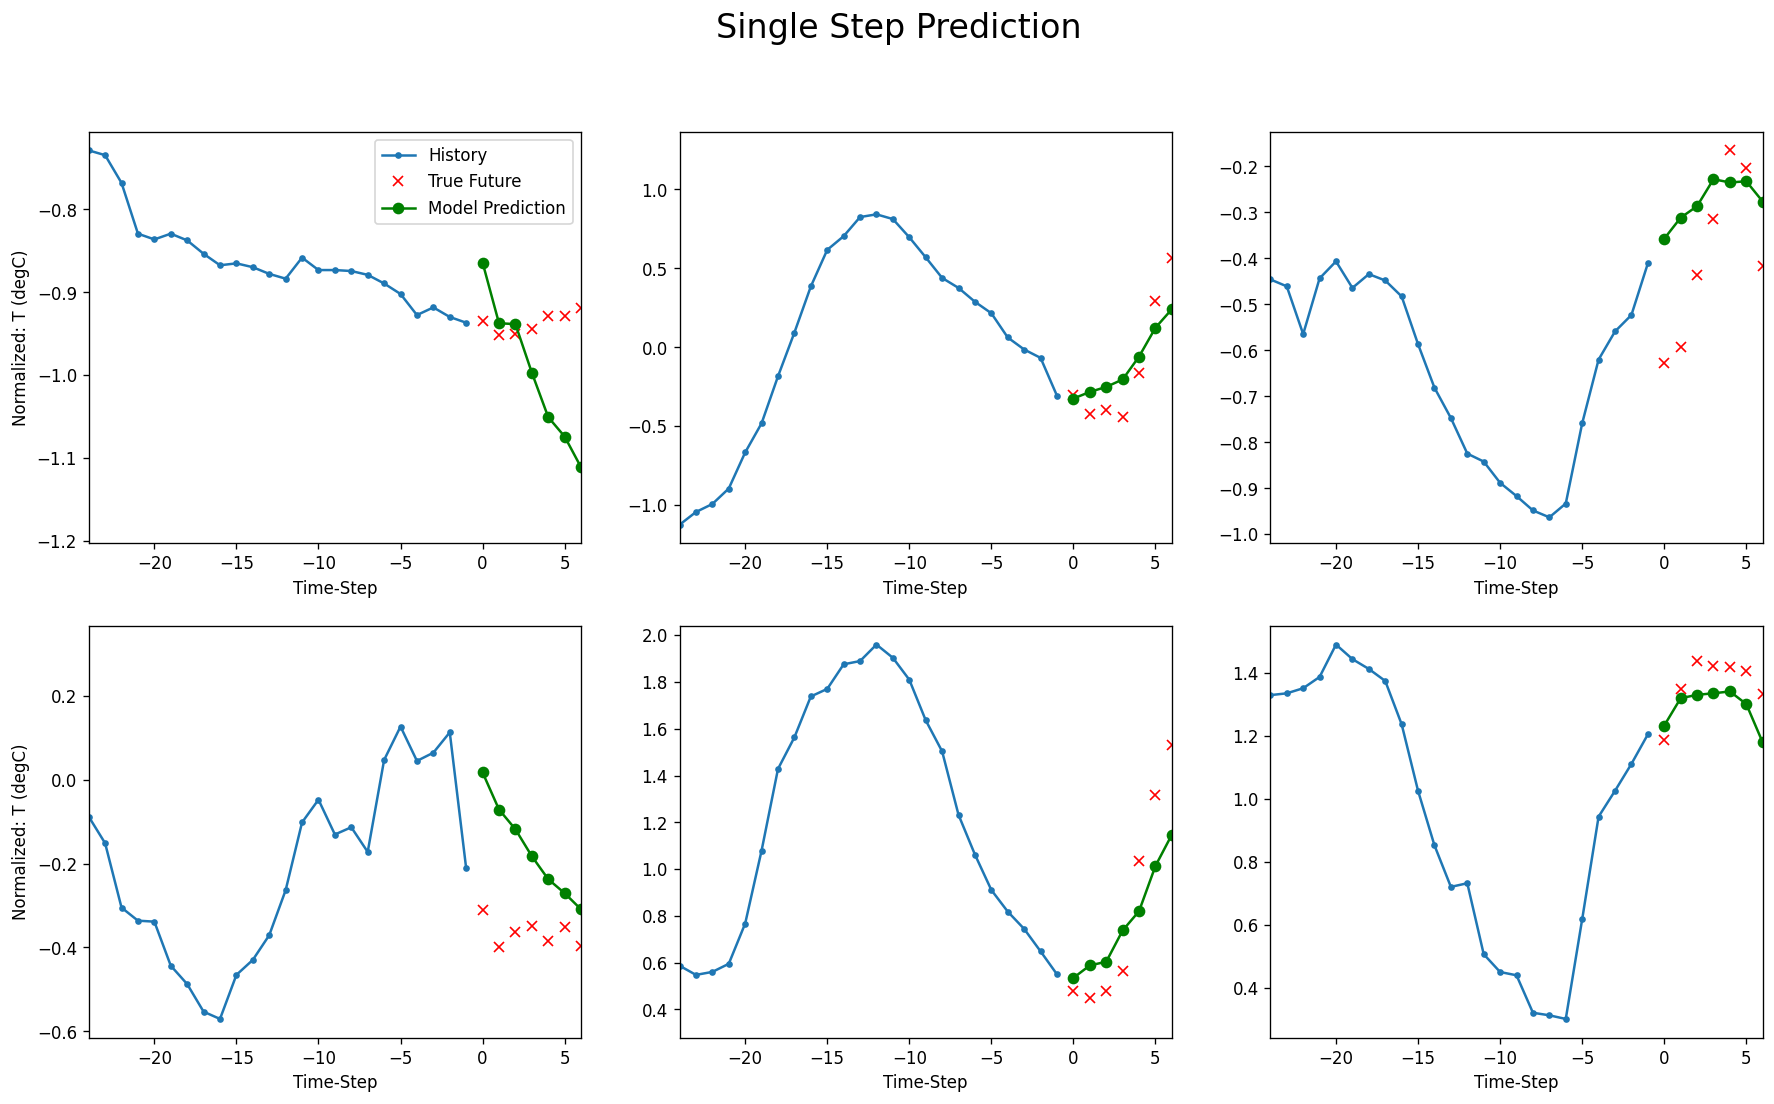

In [96]:
show_predictions(test_ds_24,model)

Label index: 0, Input index: 1
Epoch 1/5
96/96 [==============================] - 5s 23ms/step - loss: 0.4031 - last_time_step_mse: 0.4099 - val_loss: 0.1407 - val_last_time_step_mse: 0.1279 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1928 - last_time_step_mse: 0.1306 - val_loss: 0.1507 - val_last_time_step_mse: 0.1478 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1755 - last_time_step_mse: 0.1433 - val_loss: 0.1731 - val_last_time_step_mse: 0.1274 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1344 - last_time_step_mse: 0.0775 - val_loss: 0.0961 - val_last_time_step_mse: 0.0410 - lr: 5.0000e-04
Epoch 5/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1022 - last_time_step_mse: 0.0494 - val_loss: 0.0935 - val_last_time_step_mse: 0.0385 - lr: 5.0000e-04
Test Loss: 0.080
Test Metric: 0.035


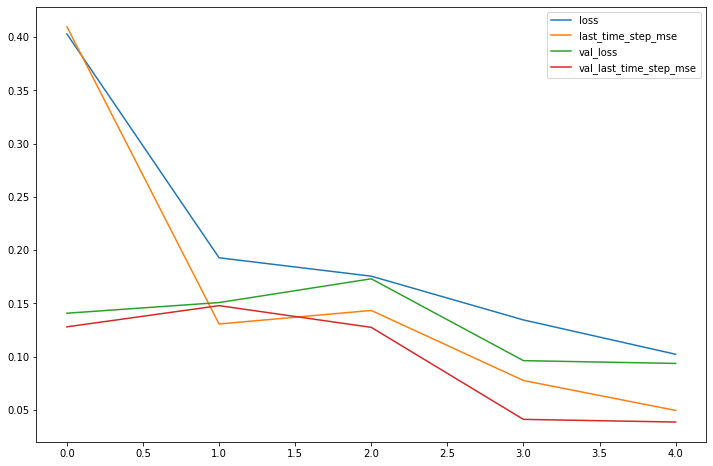

Prediction shape = (1,), pred = [-0.77]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (1,), pred = [-0.2812]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (1,), pred = [-0.318]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (1,), pred = [0.00469]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (1,), pred = [0.612]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (1,), pred = [1.289]
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)


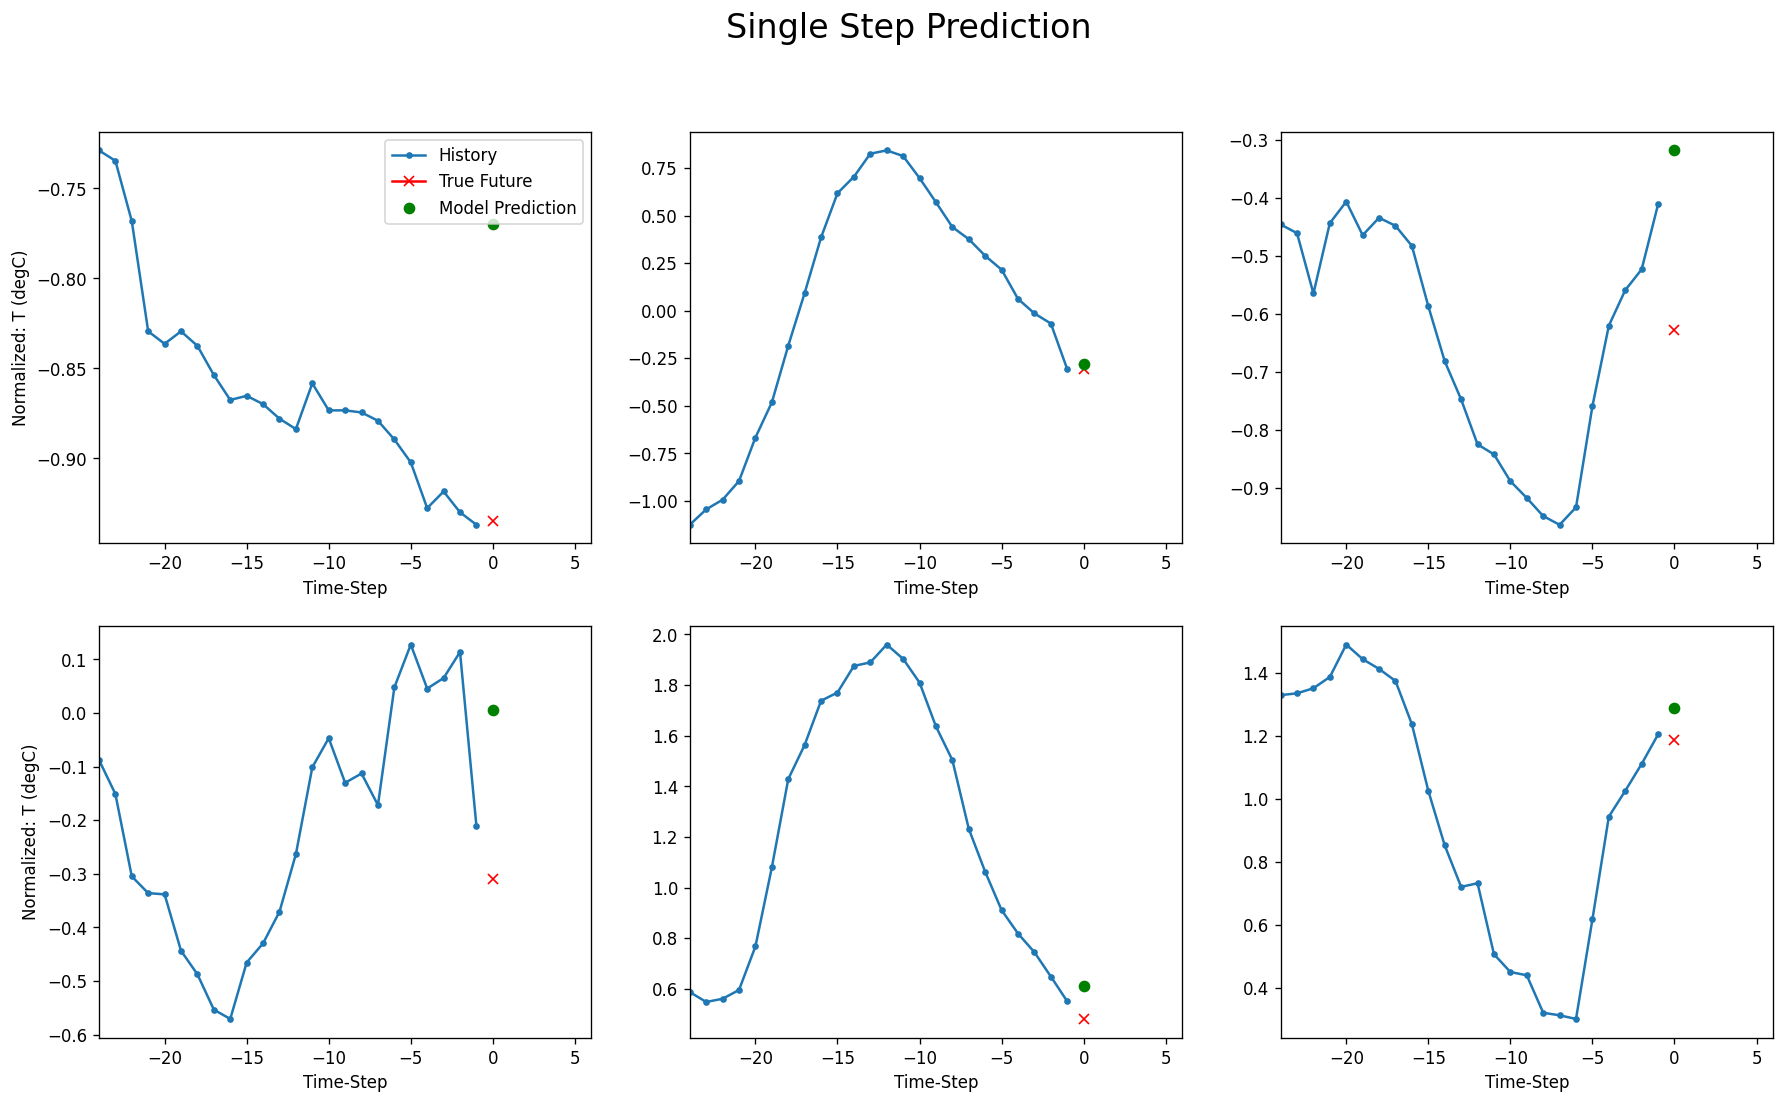

In [120]:
label_width = 24
shift = 1
model = lstm_model(label_width)
model_history, model, model_test_loss, model_test_acc = fit_and_evaluate_model(model,train_ds_24,val_ds_24,test_ds_24,shift=shift)

Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)
Prediction shape = (24,)
Prediction shape = (1,)
Target shape = (512, 24, 1)
Inpurt shape = (24,), Target shape = (1, 1)


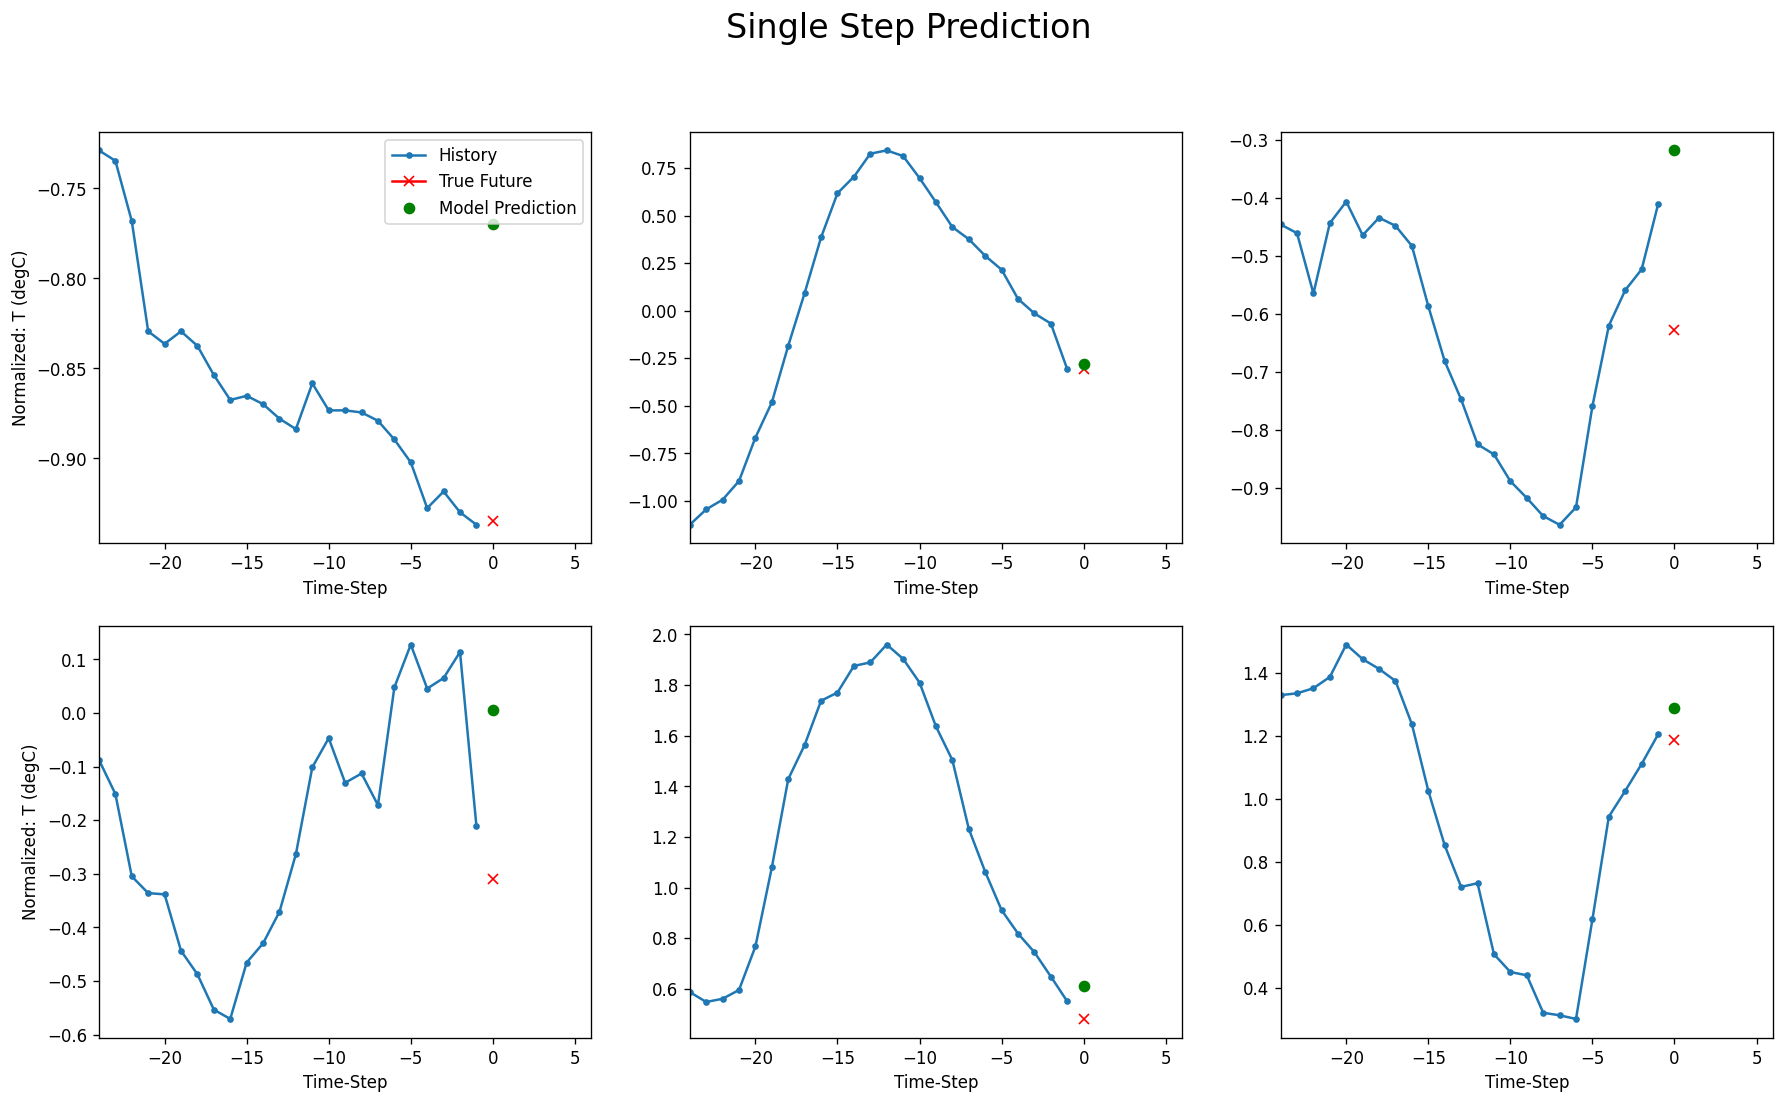

In [125]:
show_predictions(test_ds_24,model)

In [97]:
def build_iterative_model(n_output_steps:int=1,gru_rnn:bool=False)->Model:
    inputs = Input(input_shape)
    num_input_features = inputs.shape[-1]
    rnn = GRU if gru_rnn else LSTM
    # Shape [batch, time, features] => [batch, time, lstm_units]
    x = rnn(128, return_sequences=True)(inputs)
    x = rnn(256, return_sequences=True)(x)
    x = rnn(512, return_sequences=False)(x)
    # Shape => [batch, time, lstm_units] => [batch, output_steps*output_features]
    x = Dense(num_input_features,activation='linear',name='pred_features')(x)
    # Shape => [batch, output_steps, output_features]
    if n_output_steps > 1:
        y = Reshape([n_output_steps,num_input_features])(x)
    else:
        y = Reshape([num_input_features])(x)
    model = Model(inputs=inputs,outputs=y)
    return model

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 19)]          0         
                                                                 
 lstm_16 (LSTM)              (None, 24, 128)           75776     
                                                                 
 lstm_17 (LSTM)              (None, 24, 256)           394240    
                                                                 
 lstm_18 (LSTM)              (None, 512)               1574912   
                                                                 
 pred_features (Dense)       (None, 19)                9747      
                                                                 
 reshape_7 (Reshape)         (None, 19)                0         
                                                                 
Total params: 2,054,675
Trainable params: 2,054,675
Non-tra

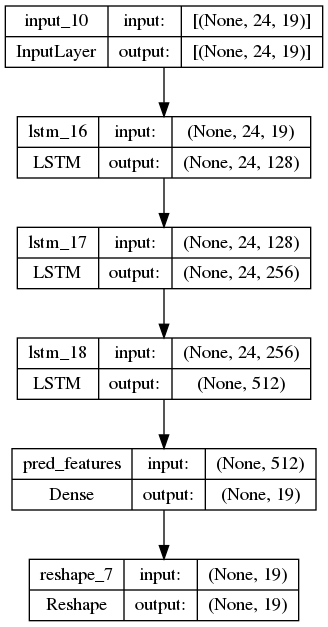

In [98]:
iterative_model = build_iterative_model()
iterative_model.summary()
# Test the model
plot_model(iterative_model,show_shapes=True,show_layer_names=True,to_file='iterative_model.png')

In [99]:
shift = 1
n_output_steps = 1
lcol = None
lci = get_label_columns_indices(dfnorm, lcol)
input_lci = dict((k, all_lci[k]) for k in all_lci.keys() if k in list(lci.keys()))
train_ds_full, val_ds_full, test_ds_full = train_val_test(shift, n_output_steps,lcol=None)


Number of samples: 96
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 19)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 28
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 19)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Number of samples: 14
Input shape: (512, 24, 19)
Type of input: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>
Target shape: (512, 19)
Type of target: <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float64'>


Label index: 1, Input index: 1
Epoch 1/5
96/96 [==============================] - 5s 22ms/step - loss: 0.4362 - last_time_step_mse: 0.2862 - val_loss: 0.3310 - val_last_time_step_mse: 0.1775 - lr: 0.0010
Epoch 2/5
96/96 [==============================] - 2s 16ms/step - loss: 0.3018 - last_time_step_mse: 0.1766 - val_loss: 0.2825 - val_last_time_step_mse: 0.1947 - lr: 0.0010
Epoch 3/5
96/96 [==============================] - 2s 16ms/step - loss: 0.2450 - last_time_step_mse: 0.1468 - val_loss: 0.1803 - val_last_time_step_mse: 0.0617 - lr: 0.0010
Epoch 4/5
96/96 [==============================] - 2s 16ms/step - loss: 0.2079 - last_time_step_mse: 0.1202 - val_loss: 0.1459 - val_last_time_step_mse: 0.0600 - lr: 0.0010
Epoch 5/5
96/96 [==============================] - 2s 16ms/step - loss: 0.1746 - last_time_step_mse: 0.0980 - val_loss: 0.1366 - val_last_time_step_mse: 0.0507 - lr: 0.0010
Test Loss: 0.147
Test Metric: 0.049


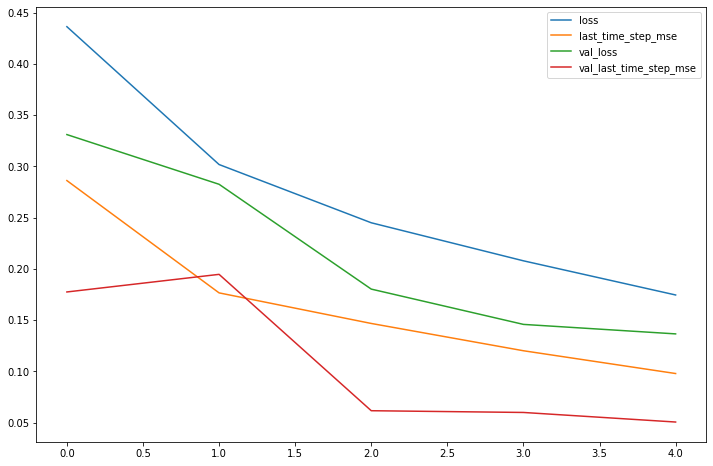

Prediction shape = (19,)
Target shape = (512, 19)
Target shape = (19,)


2023-05-03 09:44:27.782160: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: Index out of range using input dim 1; input has only 1 dims


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

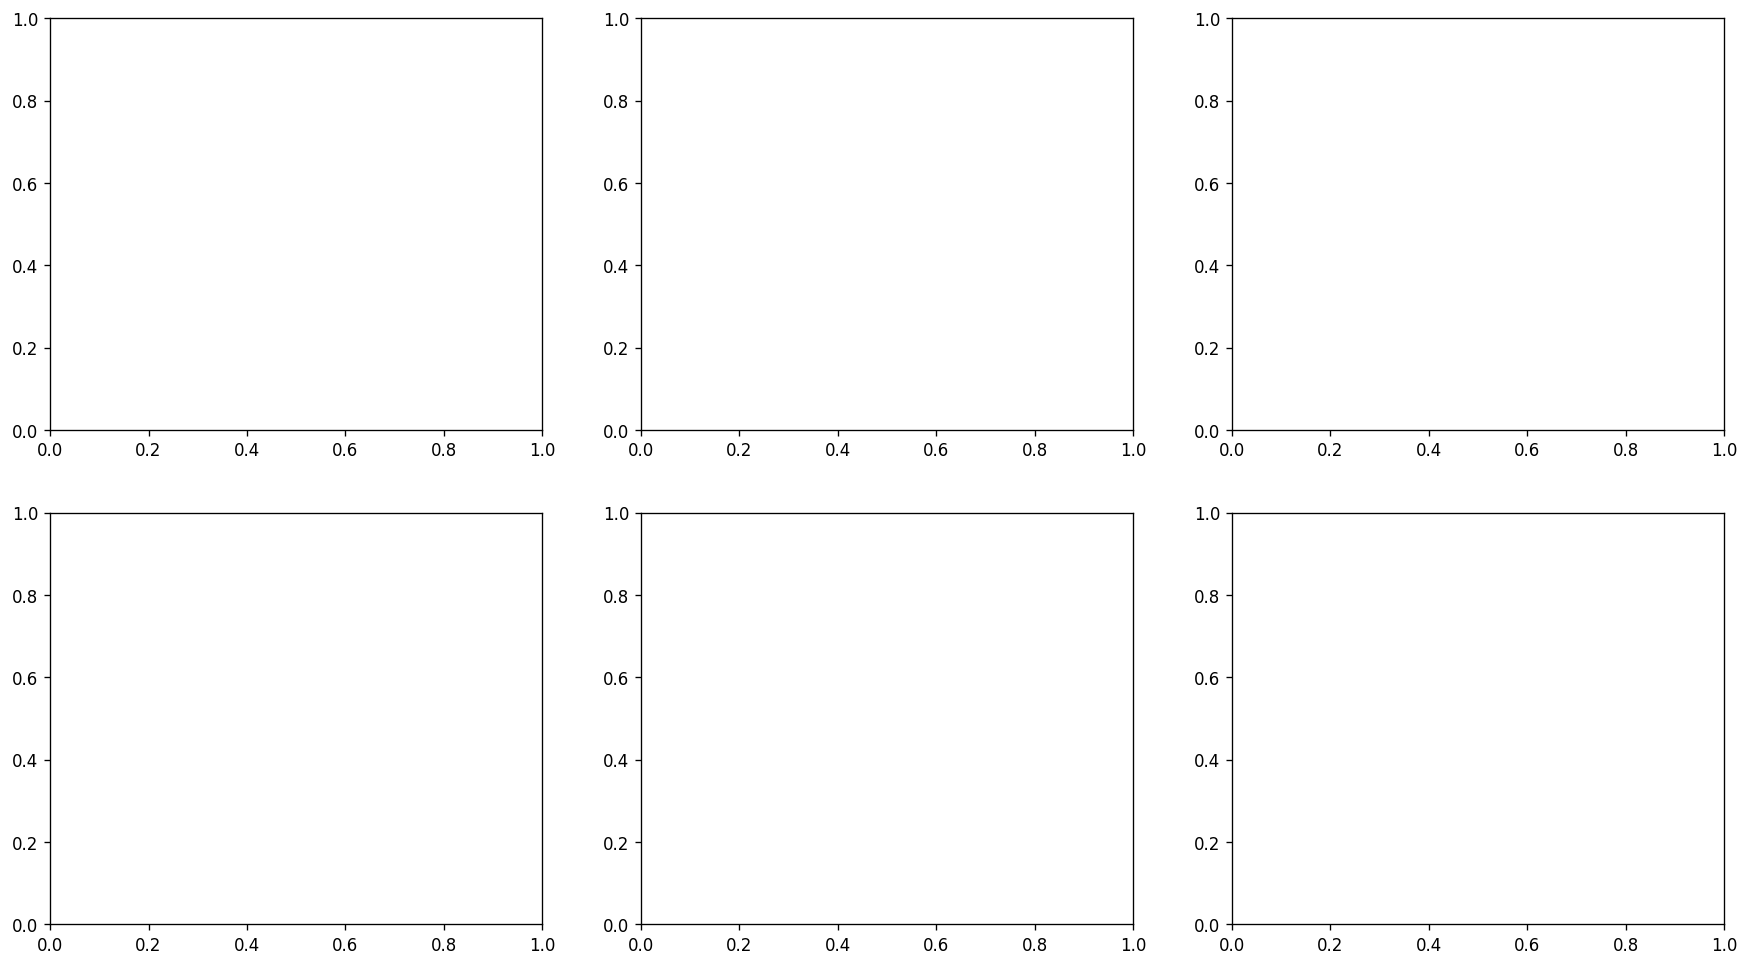

In [100]:

iterative_history, iterative_model, iterative_test_loss, iterative_test_acc = fit_and_evaluate_model(iterative_model,
                                                                                                     train_ds_full,
                                                                                                     val_ds_full,
                                                                                                     test_ds_full,
                                                                                                     shift=shift,
                                                                                                     lci=lci,
                                                                                                     input_lci=input_lci,)

Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)
Prediction shape = (19,)
Prediction shape = (1,)
Target shape = (512, 19)
Inpurt shape = (24,), Target shape = (1,)


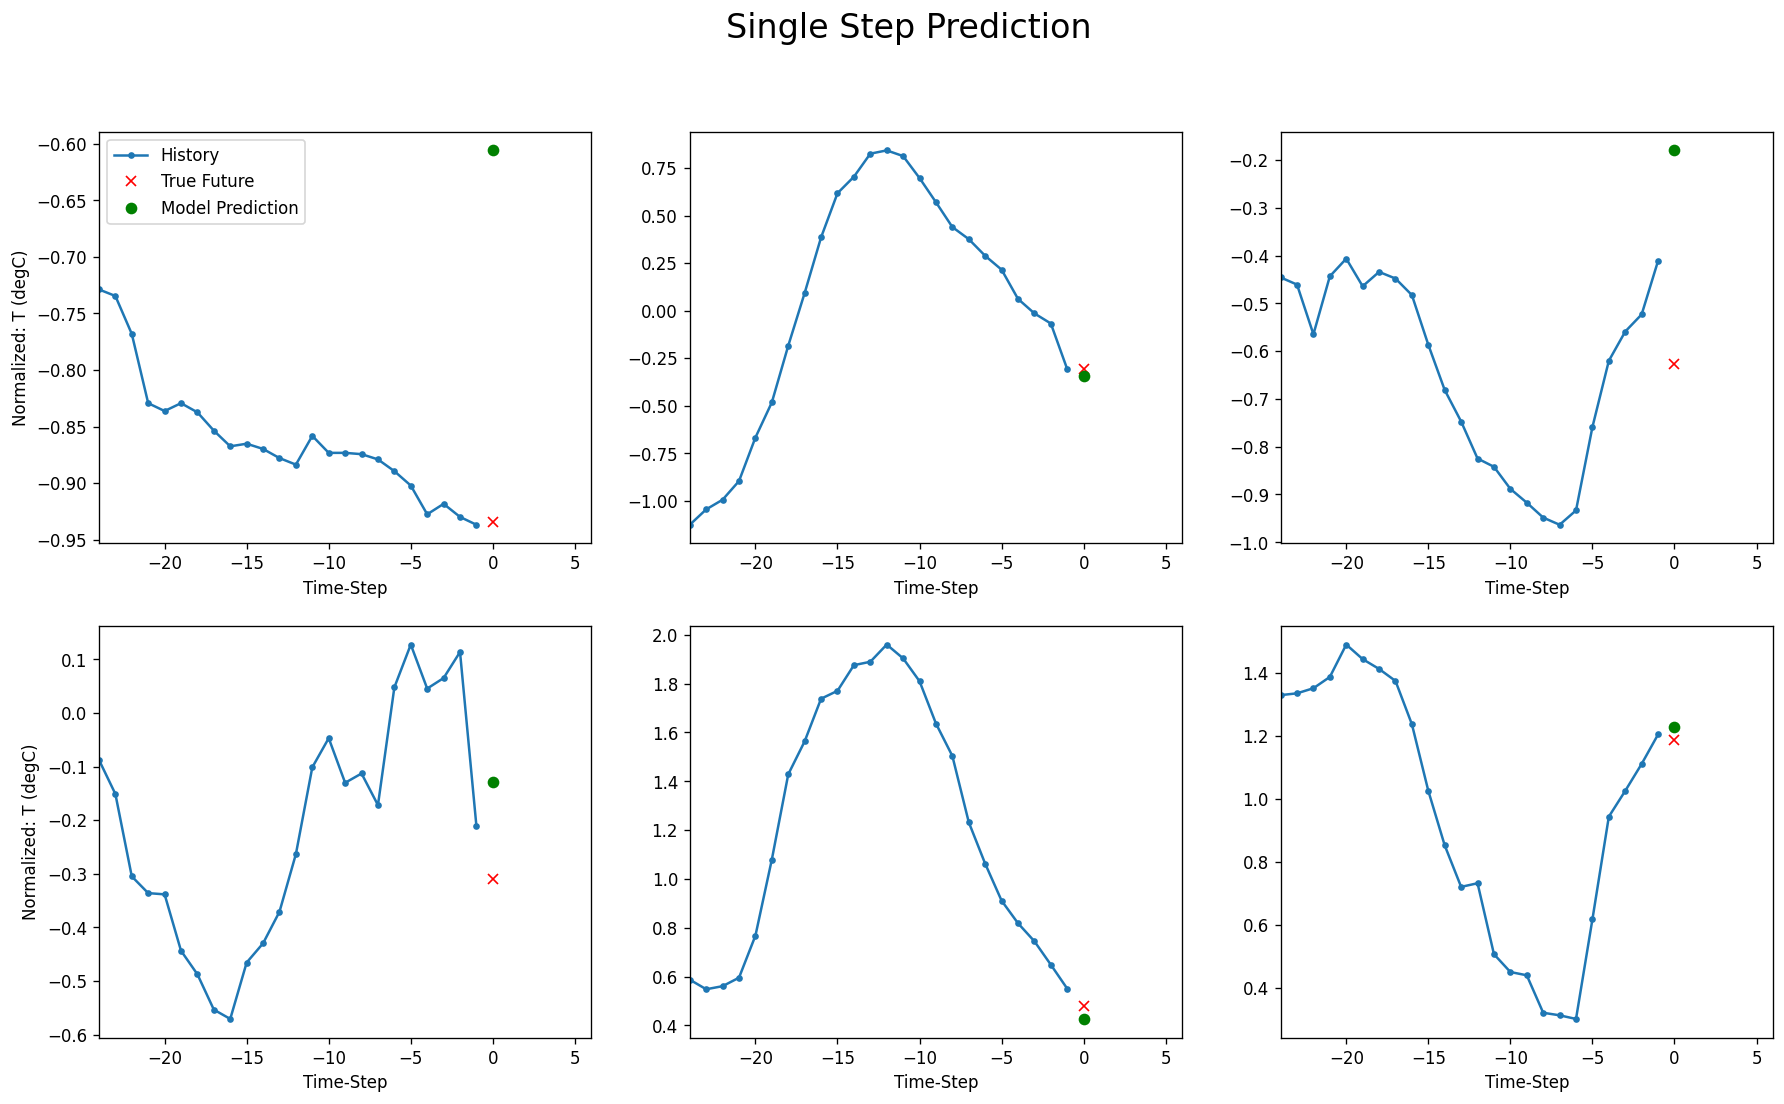

In [126]:
show_predictions(test_ds_full,iterative_model,n=6,shift=shift,lci=lci,input_lci=input_lci)

## Uppgift -- Analys
Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar dessa modeller i jämförelse med fallet i del 1 där vi bara behövde prediktera ett steg framåt?

# VG Del

## Uppgift - Återkopplad modell
Du ska som i Del2 prediktera vad temperaturen är vid timme 48. Men denna gång ska du göra en enstegsprediktion 24 gånger och hela tiden låta den senaste prediktionen vara del av invärdena till nästa stegs prediktion (Autoregressive predictions). Notera att för att detta ska fungera så måste man prediktera alla 19 värden som output och inte bara temperaturen.

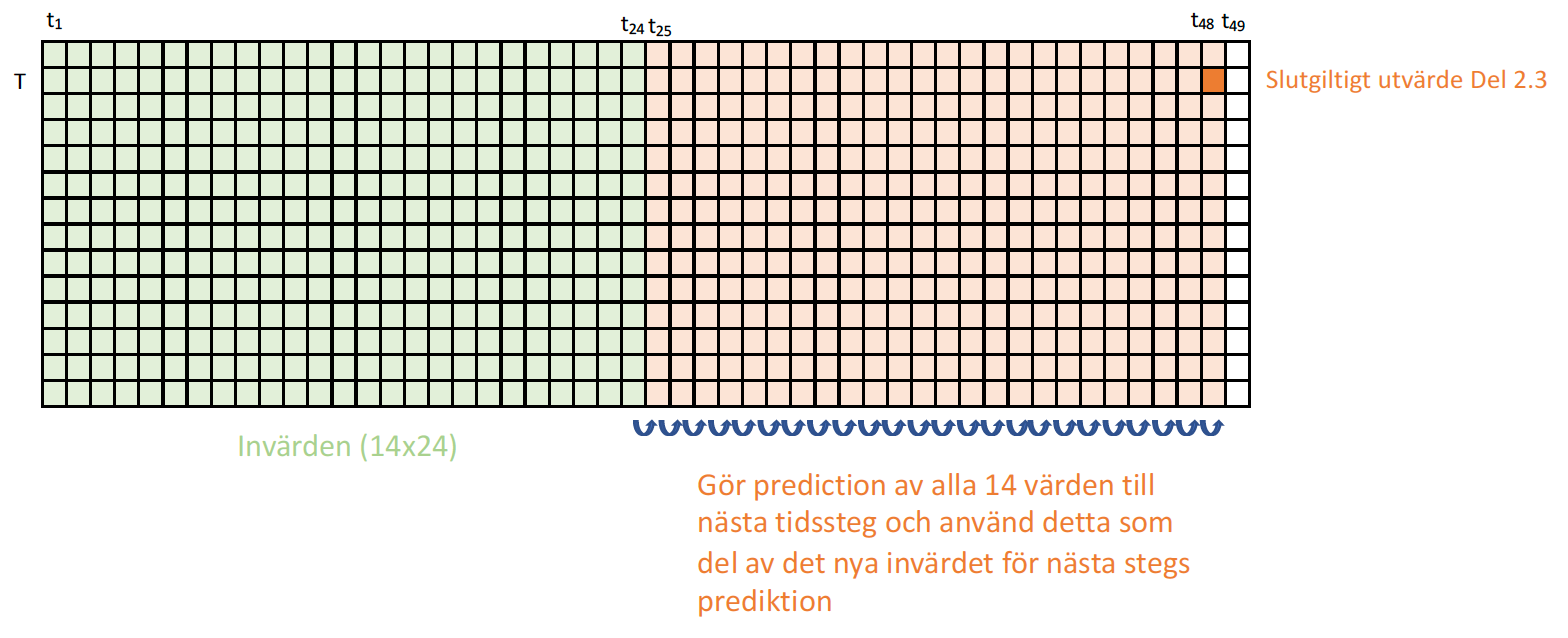

## Uppgift -- Analys
Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar denna modell i jämförelse med de du analyserade i del 2?

#Referenser
Delar av denna kod är baserat på
* Tidigare TF-exempel https://www.tensorflow.org/tutorials/structured_data/time_series
* Läroboken Kapitel 15, från "Preparing the Data for Machine Learning Models", s. 552, och dess kodexempel: https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb
* Timeseries forecasting for weather prediction https://keras.io/examples/timeseries/timeseries_weather_forecasting/